# Project Notebook

### Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from openpyxl import load_workbook

# 1. Import Datasets

In [3]:
# main data set
data_main = pd.read_csv('data/cancer_reg.csv', encoding = "ISO-8859-1")

# import data of manufactoring share
wb = load_workbook('data/industry_county_data_overview.xlsx', data_only=True)
ws = wb['new_overview']
ws_data = ws.values
# Get the first line in file as a header line
columns = next(ws_data)[0:]
# Create a DataFrame based on the second and subsequent lines of data
data_industry = pd.DataFrame(ws_data, columns=columns)

# import data of UV exposure
data_uv = pd.read_csv('data/uv-county.csv', encoding = "ISO-8859-1")

# import data with rural/urban classification
data_county_class = pd.read_excel('data/PctUrbanRural_County.xls', sheet_name='Pct urban by county')


In [4]:
# Reduce DataFrame to most important columns
data_industry = data_industry[['county_state', 'Industry Share of County GDP (Manufacturing)', 'Industry Share of County GDP (Mining, Oil, Gas)']]
data_industry

,county_state,Industry Share of County GDP (Manufacturing),"Industry Share of County GDP (Mining, Oil, Gas)"
0,Autauga_AL,0.15095,0.019244
1,Baldwin_AL,0.068274,0.002761
2,Barbour_AL,0.261618,0.088787
3,Bibb_AL,0.119731,0.030386
4,Blount_AL,0.12457,0.004438
...,...,...,...
3112,Sweetwater_WY,0.110247,0.433276
3113,Teton_WY,0.009897,0.003029
3114,Uinta_WY,0.041912,0.102798
3115,Washakie_WY,0.153798,0.048576


# 2. Data Cleaning
## 2.1 Harmonize county names

### Lower case for all column names

In [5]:
data_main.columns=[item.lower() for item in data_main.columns]
data_industry.columns=[item.lower() for item in data_industry.columns]
data_uv.columns=[item.lower() for item in data_uv.columns]
data_county_class.columns=[item.lower() for item in data_county_class]

In [6]:
#data_main.geography.to_csv('county_check.csv')

In [7]:
# Extract county name from Geography

def get_countyname(item):
    if ' County' in item:
        return item[:item.find(' County')]
    elif ' Parish' in item:
        return item[:item.find(' Parish')]
    #elif ' city' in item:
    #    return item[:item.find(' city')]
    else:
        return item[:item.find(',')]

data_main['county'] =  data_main.geography.apply(get_countyname)
# Extract state name from Geography
data_main['state'] = data_main.geography.str.split(', ').str[1]

In [8]:
data_main.state

0       Washington
1       Washington
2       Washington
3       Washington
4       Washington
           ...    
3042        Kansas
3043        Kansas
3044        Kansas
3045        Kansas
3046        Kansas
Name: state, Length: 3047, dtype: object

In [9]:
# read state abbreviation lookup table
wb2 = load_workbook('data/state_abbreviations.xlsx')
ws2 = wb2['Sheet1']
ws_data2 = ws2.values
# Get the first line in file as a header line
columns2 = next(ws_data2)[0:]
# Create a DataFrame based on the second and subsequent lines of data
state_abb = pd.DataFrame(ws_data2, columns=columns2)

In [10]:
state_abb.head()

,state,state_short
0,ALABAMA,AL
1,ALASKA,AK
2,AMERICAN SAMOA,AS
3,ARIZONA,AZ
4,ARKANSAS,AR


In [11]:
# capitalize state names in lookup table
state_abb.state = state_abb.state.str.title()
# Correct this for DC
state_abb.state = state_abb.state.str.replace('District Of Columbia','District of Columbia')

### Merge main table with lookup table

In [12]:
# merge
data_main = pd.merge(data_main, state_abb, how='left', on='state')

In [13]:
print(sorted(data_main.state.unique()))
print(sorted(state_abb.state.unique()))

['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
['Alabama', 'Alaska', 'American Samoa', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Guam', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana

### Create new column which consists of county and state name

In [14]:
# New combined column
data_main['county_state'] = data_main['county'].map(str) + '_' + data_main['state_short'].map(str)
data_main.county_state

0          Kitsap_WA
1        Kittitas_WA
2       Klickitat_WA
3           Lewis_WA
4         Lincoln_WA
            ...     
3042    Ellsworth_KS
3043       Finney_KS
3044         Ford_KS
3045     Franklin_KS
3046        Geary_KS
Name: county_state, Length: 3047, dtype: object

In [15]:
# check for duplicates
data_main.county_state[data_main.county_state.duplicated(keep=False) == True]

Series([], Name: county_state, dtype: object)

### Harmonize data_industry table

In [16]:
data_industry.head()

,county_state,industry share of county gdp (manufacturing),"industry share of county gdp (mining, oil, gas)"
0,Autauga_AL,0.15095,0.019244
1,Baldwin_AL,0.068274,0.002761
2,Barbour_AL,0.261618,0.088787
3,Bibb_AL,0.119731,0.030386
4,Blount_AL,0.12457,0.004438


In [17]:
# kick out asterisks and (independent city from county)
data_industry.county_state = data_industry.county_state.str.replace(', ','_', regex=False)
data_industry.county_state = data_industry.county_state.str.replace('*','', regex=False)
data_industry.county_state = data_industry.county_state.str.replace('(Independent City)','city', regex=False)
data_industry.county_state = data_industry.county_state.str.replace('(city)','city', regex=False)
# rename columns
data_industry.rename(columns={"industry share of county gdp (manufacturing)": "industry_share_manufacturing", "industry share of county gdp (mining, oil, gas)": "industry_share_mineoilgas"}, inplace=True)

### Harmonize data_uv table

In [18]:
data_uv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3108 entries, 0 to 3107
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   statename    3108 non-null   object
 1   state_abr    3108 non-null   object
 2   county_fips  3108 non-null   int64 
 3   county name  3108 non-null   object
 4   uv_ wh/m_    3108 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 121.5+ KB


In [19]:
# Create new Column county_state
data_uv['county_state'] = data_uv['county name'].map(str) + '_' + data_uv['state_abr'].map(str)
data_uv['county_state']

0          Autauga_AL
1          Baldwin_AL
2          Barbour_AL
3             Bibb_AL
4           Blount_AL
            ...      
3103    Sweetwater_WY
3104         Teton_WY
3105         Uinta_WY
3106      Washakie_WY
3107        Weston_WY
Name: county_state, Length: 3108, dtype: object

In [20]:
# Rename column
data_uv.rename(columns={"uv_ wh/m_": "uv"}, inplace=True)

# dropping unnessessary columns
data_uv = data_uv[['county_state','uv']]
data_uv.head()

,county_state,uv
0,Autauga_AL,4563
1,Baldwin_AL,4492
2,Barbour_AL,4642
3,Bibb_AL,4499
4,Blount_AL,4416


### Harmonize data_county_class table

In [21]:
data_county_class

,state,county,statename,countyname,pop_cou,area_cou,pop_urban,poppct_urban,area_urban,areapct_urban,...,pop_uc,poppct_uc,area_uc,areapct_uc,popden_uc,pop_rural,poppct_rural,area_rural,areapct_rural,popden_rural
0,1,1,Alabama,Autauga,54571,1539582278,31650,58.00,50882539,3.30,...,0,0.00,0,0.00,NaN,22921,42.00,1488699739,96.70,39.9
1,1,3,Alabama,Baldwin,182265,4117521611,105205,57.72,275001368,6.68,...,41556,22.80,111381848,2.71,966.3,77060,42.28,3842520243,93.32,51.9
2,1,5,Alabama,Barbour,27457,2291818968,8844,32.21,17447656,0.76,...,8844,32.21,17447656,0.76,1312.8,18613,67.79,2274371312,99.24,21.2
3,1,7,Alabama,Bibb,22915,1612480789,7252,31.65,18903236,1.17,...,7252,31.65,18903236,1.17,993.6,15663,68.35,1593577553,98.83,25.5
4,1,9,Alabama,Blount,57322,1669961855,5760,10.05,10874700,0.65,...,5374,9.38,9851721,0.59,1412.8,51562,89.95,1659087155,99.35,80.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3216,72,145,Puerto Rico,Vega Baja,59662,118766810,57170,95.82,72771265,61.27,...,0,0.00,0,0.00,NaN,2492,4.18,45995545,38.73,140.3
3217,72,147,Puerto Rico,Vieques,9301,131488427,8230,88.49,13439063,10.22,...,8230,88.49,13439063,10.22,1586.1,1071,11.51,118049364,89.78,23.5
3218,72,149,Puerto Rico,Villalba,26073,92298550,22564,86.54,39316802,42.60,...,0,0.00,0,0.00,NaN,3509,13.46,52981748,57.40,171.5
3219,72,151,Puerto Rico,Yabucoa,37941,143005172,32192,84.85,62090343,43.42,...,0,0.00,0,0.00,NaN,5749,15.15,80914829,56.58,184.0


In [22]:
# drop state column which contains a number
data_county_class.drop('state', axis=1, inplace = True)
# rename the statename column
data_county_class.rename(columns={'statename': 'state'}, inplace=True)

In [23]:
# merge with abbreviation table
data_county_class = pd.merge(data_county_class, state_abb, how='left', on='state')

In [24]:
# Create new Column county_state
data_county_class['county_state'] = data_county_class['countyname'].map(str) + '_' + data_county_class['state_short'].map(str)
data_county_class['county_state']

0         Autauga_AL
1         Baldwin_AL
2         Barbour_AL
3            Bibb_AL
4          Blount_AL
            ...     
3216    Vega Baja_PR
3217      Vieques_PR
3218     Villalba_PR
3219      Yabucoa_PR
3220        Yauco_PR
Name: county_state, Length: 3221, dtype: object

In [25]:
# Drop unnessessary columns
data_county_class = data_county_class[['county_state','poppct_urban', 'poppct_rural']]
data_county_class.head()

,county_state,poppct_urban,poppct_rural
0,Autauga_AL,58.00,42.00
1,Baldwin_AL,57.72,42.28
2,Barbour_AL,32.21,67.79
3,Bibb_AL,31.65,68.35
4,Blount_AL,10.05,89.95


In [26]:
# Look for duplicates
data_county_class[data_county_class.county_state.duplicated(keep=False)]

,county_state,poppct_urban,poppct_rural
1195,Baltimore_MD,93.47,6.53
1216,Baltimore_MD,100.00,0.00
1578,St. Louis_MO,98.86,1.14
1597,St. Louis_MO,100.00,0.00
2829,Bedford_VA,21.57,78.43
2848,Fairfax_VA,98.61,1.39
2852,Franklin_VA,10.77,89.23
2895,Richmond_VA,0.00,100.00
2896,Roanoke_VA,81.46,18.54
2916,Bedford_VA,97.94,2.06


In [27]:
# Manually change the counties that are actually cities
data_county_class.iloc[1216, data_county_class.columns.get_loc('county_state')] = 'Baltimore city_MD'
data_county_class.iloc[1578, data_county_class.columns.get_loc('county_state')] = 'St. Louis city_MO'
data_county_class.iloc[2916, data_county_class.columns.get_loc('county_state')] = 'Bedford city_VA'
data_county_class.iloc[2925, data_county_class.columns.get_loc('county_state')] = 'Fairfax city_VA'
data_county_class.iloc[2927, data_county_class.columns.get_loc('county_state')] = 'Franklin city_VA'
data_county_class.iloc[2945, data_county_class.columns.get_loc('county_state')] = 'Richmond city_VA'
data_county_class.iloc[2946, data_county_class.columns.get_loc('county_state')] = 'Roanoke city_VA'

## 2.2 Data Joining

### Join data_main with data_industry

In [28]:
data_main = pd.merge(data_main, data_industry, how='left', on='county_state')

In [29]:
data_main[(data_main.industry_share_manufacturing.isna() == True)].count

<bound method DataFrame.count of       avganncount  avgdeathsperyear  target_deathrate  incidencerate  \
127   1962.667684               145             193.5     453.549422   
216    309.000000               120             153.3     396.200000   
225    346.000000               156             176.8     399.000000   
228    155.000000                59             172.1     437.000000   
229   1142.000000               407             150.1     373.700000   
233    493.000000               204             155.9     400.500000   
234    115.000000                58             159.2     338.000000   
235    378.000000               157             156.1     400.200000   
240     97.000000                43             181.8     405.700000   
241    518.000000               191             172.5     449.400000   
247    312.000000               136             176.7     420.800000   
249    176.000000               106             223.4     367.300000   
251    272.000000              

### Fill missing values for industry share with mean share of respective state

In [30]:
data_main['industry_share_manufacturing'] = data_main['industry_share_manufacturing'].fillna(data_main.groupby('state')['industry_share_manufacturing'].transform('mean'))
data_main['industry_share_mineoilgas'] = data_main['industry_share_mineoilgas'].fillna(data_main.groupby('state')['industry_share_mineoilgas'].transform('mean'))
data_main.industry_share_manufacturing.value_counts(dropna = False)

0.000000    295
0.142449     42
0.025427      1
0.152833      1
0.145394      1
           ... 
0.017131      1
0.025018      1
0.014692      1
0.004929      1
0.027242      1
Name: industry_share_manufacturing, Length: 2712, dtype: int64

### Join data_main with data_uv

In [31]:
data_main = pd.merge(data_main, data_uv, how='left', on='county_state')
data_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3053 entries, 0 to 3052
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   avganncount                   3053 non-null   float64
 1   avgdeathsperyear              3053 non-null   int64  
 2   target_deathrate              3053 non-null   float64
 3   incidencerate                 3053 non-null   float64
 4   medincome                     3053 non-null   int64  
 5   popest2015                    3053 non-null   int64  
 6   povertypercent                3053 non-null   float64
 7   studypercap                   3053 non-null   float64
 8   binnedinc                     3053 non-null   object 
 9   medianage                     3053 non-null   float64
 10  medianagemale                 3053 non-null   float64
 11  medianagefemale               3053 non-null   float64
 12  geography                     3053 non-null   object 
 13  avg

In [32]:
# check for missing values
data_main[(data_main['uv'].isna() == True)].count

<bound method DataFrame.count of       avganncount  avgdeathsperyear  target_deathrate  incidencerate  \
166         799.0               319             150.8          381.0   
254         405.0               165             135.4          317.6   
255          64.0                58             226.6          265.7   
256          46.0                19             240.8          578.2   
257         250.0                60             178.2          718.9   
258         995.0               378             182.2          458.3   
259         117.0                43             159.3          493.6   
260         320.0               130             207.4          539.0   
261          55.0                16             137.6          447.7   
262          51.0                25             221.7          468.0   
263         120.0                39             180.3          566.3   
264         709.0               270             190.3          491.9   
265         190.0              

### Fill missing values for UV with mean share of respective state

In [33]:
data_main['uv'] = data_main['uv'].fillna(data_main.groupby('state')['uv'].transform('mean'))
data_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3053 entries, 0 to 3052
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   avganncount                   3053 non-null   float64
 1   avgdeathsperyear              3053 non-null   int64  
 2   target_deathrate              3053 non-null   float64
 3   incidencerate                 3053 non-null   float64
 4   medincome                     3053 non-null   int64  
 5   popest2015                    3053 non-null   int64  
 6   povertypercent                3053 non-null   float64
 7   studypercap                   3053 non-null   float64
 8   binnedinc                     3053 non-null   object 
 9   medianage                     3053 non-null   float64
 10  medianagemale                 3053 non-null   float64
 11  medianagefemale               3053 non-null   float64
 12  geography                     3053 non-null   object 
 13  avg

In [34]:
# check for missing values
data_main[(data_main['uv'].isna() == True)].head()

,avganncount,avgdeathsperyear,target_deathrate,incidencerate,medincome,popest2015,povertypercent,studypercap,binnedinc,medianage,...,pctotherrace,pctmarriedhouseholds,birthrate,county,state,state_short,county_state,industry_share_manufacturing,industry_share_mineoilgas,uv
2318,911.0,343,147.6,402.7,51887,196428,18.1,0.000000,"(51046.4, 54545.6]",41.1,...,2.082702,47.978416,6.030934,Hawaii,Hawaii,HI,Hawaii_HI,0.000000,0.000049,NaN
2319,4646.0,1562,135.0,425.2,73985,998714,9.8,708.911660,"(61494.5, 125635]",36.9,...,0.915383,52.713161,6.457474,Honolulu,Hawaii,HI,Honolulu_HI,0.025372,0.001251,NaN
2320,326.0,130,149.4,392.2,58883,71735,12.3,655.189238,"(54545.6, 61494.5]",41.6,...,0.665796,54.706539,4.798814,Kauai,Hawaii,HI,Kauai_HI,0.000000,0.001090,NaN
2321,734.0,247,139.9,418.3,64916,164637,13.1,103.257469,"(61494.5, 125635]",40.0,...,0.870927,50.799618,6.347296,Maui,Hawaii,HI,Maui_HI,0.008457,0.000797,NaN
2719,8.0,3,203.3,201.3,68387,5702,9.9,0.000000,"(61494.5, 125635]",36.8,...,5.295567,42.882250,4.391052,Aleutians West Census Area,Alaska,AK,Aleutians West Census Area_AK,0.419544,0.023742,NaN


It seems like Alaska and Hawaii are missing in the UV table. I'll later decide if I kick both states from the dataset or kick the UV numbers instead.

### Join data_main with data_county_class

In [35]:
data_main = pd.merge(data_main, data_county_class, how='left', on='county_state')

## 2.3 Data transforming

### Check data types

In [36]:
data_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3053 entries, 0 to 3052
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   avganncount                   3053 non-null   float64
 1   avgdeathsperyear              3053 non-null   int64  
 2   target_deathrate              3053 non-null   float64
 3   incidencerate                 3053 non-null   float64
 4   medincome                     3053 non-null   int64  
 5   popest2015                    3053 non-null   int64  
 6   povertypercent                3053 non-null   float64
 7   studypercap                   3053 non-null   float64
 8   binnedinc                     3053 non-null   object 
 9   medianage                     3053 non-null   float64
 10  medianagemale                 3053 non-null   float64
 11  medianagefemale               3053 non-null   float64
 12  geography                     3053 non-null   object 
 13  avg

In [37]:
data_main.describe()

,avganncount,avgdeathsperyear,target_deathrate,incidencerate,medincome,popest2015,povertypercent,studypercap,medianage,medianagemale,...,pctblack,pctasian,pctotherrace,pctmarriedhouseholds,birthrate,industry_share_manufacturing,industry_share_mineoilgas,uv,poppct_urban,poppct_rural
count,3053.000000,3053.000000,3053.000000,3053.000000,3053.000000,3.053000e+03,3053.000000,3053.000000,3053.000000,3053.000000,...,3053.000000,3053.000000,3053.000000,3053.000000,3053.000000,3053.000000,3053.000000,3031.000000,3053.000000,3053.000000
mean,610.126938,187.363249,178.626728,448.245228,47098.507697,1.034629e+05,16.868031,155.342205,45.264887,39.571471,...,9.123786,1.262336,1.982211,51.245417,5.640925,0.142743,0.046957,4297.953606,41.928238,58.071765
std,1421.266302,505.932866,27.746053,54.535801,12094.325334,3.299452e+05,6.410199,529.143026,45.260401,5.222515,...,14.530692,2.627900,3.514961,6.569959,1.984728,0.132637,0.129821,419.057080,31.207262,31.207260
min,6.000000,3.000000,59.700000,201.300000,22640.000000,8.270000e+02,3.200000,0.000000,22.300000,22.400000,...,0.000000,0.000000,0.000000,22.992490,0.000000,0.000000,0.000000,3012.000000,0.000000,0.000000
25%,76.000000,28.000000,161.200000,420.300000,38887.000000,1.170300e+04,12.100000,0.000000,37.700000,36.400000,...,0.621371,0.254714,0.295421,47.756410,4.523580,0.038605,0.000261,3959.000000,15.160000,32.930000
50%,171.000000,62.000000,178.100000,453.549422,45219.000000,2.677700e+04,15.900000,0.000000,41.000000,39.600000,...,2.274510,0.550796,0.826185,51.669941,5.381478,0.110233,0.002693,4270.000000,41.090000,58.910000
75%,519.000000,149.000000,195.200000,480.800000,52513.000000,6.887900e+04,20.400000,83.840677,44.000000,42.500000,...,10.530371,1.223758,2.176268,55.396115,6.491885,0.210747,0.018307,4571.000000,67.070000,84.840000
max,38150.000000,14010.000000,362.800000,1206.900000,125635.000000,1.017029e+07,47.400000,9762.308998,624.000000,64.700000,...,85.947799,42.619425,41.930251,78.075397,21.326165,0.894266,0.978804,5723.000000,100.000000,100.000000


In [38]:
# Harmonize percentages
data_main.industry_share_manufacturing = data_main.industry_share_manufacturing * 100
data_main.industry_share_mineoilgas = data_main.industry_share_mineoilgas * 100

### Check for missing values

In [39]:
data_main.isna().sum()

avganncount                        0
avgdeathsperyear                   0
target_deathrate                   0
incidencerate                      0
medincome                          0
popest2015                         0
povertypercent                     0
studypercap                        0
binnedinc                          0
medianage                          0
medianagemale                      0
medianagefemale                    0
geography                          0
avghouseholdsize                   0
percentmarried                     0
pctnohs18_24                       0
pcths18_24                         0
pctsomecol18_24                 2290
pctbachdeg18_24                    0
pcths25_over                       0
pctbachdeg25_over                  0
pctemployed16_over               152
pctunemployed16_over               0
pctprivatecoverage                 0
pctprivatecoveragealone          611
pctempprivcoverage                 0
pctpubliccoverage                  0
p

### Fill missing values for the column pctsomecol 18-24

In [40]:
#data_main.to_csv('export for tableau.csv')
data_main['pctsomecol18_24'] = data_main['pctsomecol18_24'].fillna(100 - data_main['pctnohs18_24'] - data_main['pcths18_24'] - data_main['pctbachdeg18_24'])

### Filling missing values for pctemployed16_over

In [41]:
# Create a statewide ratio between employed and unemployed
data_main['ratioemployment'] = data_main.groupby('state')['pctemployed16_over'].transform('mean')/data_main.groupby('state')['pctunemployed16_over'].transform('mean')
data_main['ratioemployment']

0        5.829581
1        5.829581
2        5.829581
3        5.829581
4        5.829581
          ...    
3048    13.217273
3049    13.217273
3050    13.217273
3051    13.217273
3052    13.217273
Name: ratioemployment, Length: 3053, dtype: float64

In [42]:
# Fill the missing values with the product of pctunemployed & ratioemployment
data_main['pctemployed16_over'] = data_main['pctemployed16_over'].fillna(data_main['pctunemployed16_over'] * data_main['ratioemployment'])

In [43]:
data_main[['pctemployed16_over','pctunemployed16_over']].head(20)

,pctemployed16_over,pctunemployed16_over
0,51.900000,8.0
1,55.900000,7.8
2,45.900000,7.0
3,48.300000,12.1
4,48.200000,4.8
5,44.100000,12.9
6,51.800000,8.9
7,40.900000,8.9
8,39.500000,10.3
9,56.600000,9.2


### Fill missing values for pctprivatecoveragealone

<AxesSubplot:xlabel='pctprivatecoveragealone', ylabel='pctempprivcoverage'>

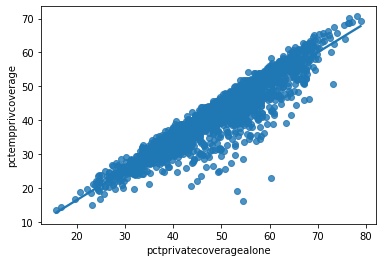

In [44]:
# Draw a scatterplott
sns.regplot(x=data_main["pctprivatecoveragealone"], y=data_main["pctempprivcoverage"])

There seems to be a correlation between pctprivatecoveragealone and pctempprivatecoverage exept for some outliers

In [45]:
# Create a statewide ratio between both variables
data_main['ratiocoverage'] = data_main.groupby('state')['pctprivatecoveragealone'].transform('mean')/data_main.groupby('state')['pctempprivcoverage'].transform('mean')
data_main['ratiocoverage']

0       1.208875
1       1.208875
2       1.208875
3       1.208875
4       1.208875
          ...   
3048    1.226752
3049    1.226752
3050    1.226752
3051    1.226752
3052    1.226752
Name: ratiocoverage, Length: 3053, dtype: float64

In [46]:
# Fill the missing values with the product of pctempprivcoverage & ratiocoverage
data_main['pctprivatecoveragealone'] = data_main['pctprivatecoveragealone'].fillna(data_main['pctempprivcoverage'] * data_main['ratiocoverage'])

In [47]:
data_main[['pctprivatecoveragealone','pctempprivcoverage']].head(20)

,pctprivatecoveragealone,pctempprivcoverage
0,50.289207,41.6
1,53.800000,43.6
2,43.500000,34.9
3,40.300000,35.0
4,43.900000,35.1
5,38.800000,32.6
6,35.000000,28.3
7,33.100000,25.9
8,37.800000,29.9
9,53.674058,44.4


In [48]:
data_main.to_csv('export_to_tableau.csv')

### Binning of the data using qcut

In [49]:
data_main.describe()

,avganncount,avgdeathsperyear,target_deathrate,incidencerate,medincome,popest2015,povertypercent,studypercap,medianage,medianagemale,...,pctotherrace,pctmarriedhouseholds,birthrate,industry_share_manufacturing,industry_share_mineoilgas,uv,poppct_urban,poppct_rural,ratioemployment,ratiocoverage
count,3053.000000,3053.000000,3053.000000,3053.000000,3053.000000,3.053000e+03,3053.000000,3053.000000,3053.000000,3053.000000,...,3053.000000,3053.000000,3053.000000,3053.000000,3053.000000,3031.000000,3053.000000,3053.000000,3053.000000,3053.000000
mean,610.126938,187.363249,178.626728,448.245228,47098.507697,1.034629e+05,16.868031,155.342205,45.264887,39.571471,...,1.982211,51.245417,5.640925,14.274287,4.695685,4297.953606,41.928238,58.071765,7.827693,1.178618
std,1421.266302,505.932866,27.746053,54.535801,12094.325334,3.299452e+05,6.410199,529.143026,45.260401,5.222515,...,3.514961,6.569959,1.984728,13.263709,12.982104,419.057080,31.207262,31.207260,3.677470,0.058723
min,6.000000,3.000000,59.700000,201.300000,22640.000000,8.270000e+02,3.200000,0.000000,22.300000,22.400000,...,0.000000,22.992490,0.000000,0.000000,0.000000,3012.000000,0.000000,0.000000,3.791086,1.056429
25%,76.000000,28.000000,161.200000,420.300000,38887.000000,1.170300e+04,12.100000,0.000000,37.700000,36.400000,...,0.295421,47.756410,4.523580,3.860509,0.026069,3959.000000,15.160000,32.930000,5.207784,1.140009
50%,171.000000,62.000000,178.100000,453.549422,45219.000000,2.677700e+04,15.900000,0.000000,41.000000,39.600000,...,0.826185,51.669941,5.381478,11.023347,0.269338,4270.000000,41.090000,58.910000,7.025973,1.172764
75%,519.000000,149.000000,195.200000,480.800000,52513.000000,6.887900e+04,20.400000,83.840677,44.000000,42.500000,...,2.176268,55.396115,6.491885,21.074741,1.830721,4571.000000,67.070000,84.840000,8.432822,1.196714
max,38150.000000,14010.000000,362.800000,1206.900000,125635.000000,1.017029e+07,47.400000,9762.308998,624.000000,64.700000,...,41.930251,78.075397,21.326165,89.426572,97.880371,5723.000000,100.000000,100.000000,22.803272,1.324858


In [50]:
# Move numericals to dedicated dataframe
dfnum = data_main.select_dtypes('number')
dfnum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3053 entries, 0 to 3052
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   avganncount                   3053 non-null   float64
 1   avgdeathsperyear              3053 non-null   int64  
 2   target_deathrate              3053 non-null   float64
 3   incidencerate                 3053 non-null   float64
 4   medincome                     3053 non-null   int64  
 5   popest2015                    3053 non-null   int64  
 6   povertypercent                3053 non-null   float64
 7   studypercap                   3053 non-null   float64
 8   medianage                     3053 non-null   float64
 9   medianagemale                 3053 non-null   float64
 10  medianagefemale               3053 non-null   float64
 11  avghouseholdsize              3053 non-null   float64
 12  percentmarried                3053 non-null   float64
 13  pct

In [51]:
# Bin each column and write ordinary integers into each row
dfnum_bins = pd.DataFrame()
for i, column in enumerate(dfnum):
    dfnum_bins[column + 'q'] = pd.qcut(dfnum[column],5,duplicates='drop',labels=False)
print (dfnum)

      avganncount  avgdeathsperyear  target_deathrate  incidencerate  \
0     1397.000000               469             164.9     489.800000   
1      173.000000                70             161.3     411.600000   
2      102.000000                50             174.7     349.700000   
3      427.000000               202             194.8     430.400000   
4       57.000000                26             144.4     350.100000   
...           ...               ...               ...            ...   
3048  1962.667684                15             149.6     453.549422   
3049  1962.667684                43             150.1     453.549422   
3050  1962.667684                46             153.9     453.549422   
3051  1962.667684                52             175.0     453.549422   
3052  1962.667684                48             213.6     453.549422   

      medincome  popest2015  povertypercent  studypercap  medianage  \
0         61898      260131            11.2   499.748204       3

In [52]:
# check for missing values
dfnum_bins.isnull().sum()

avganncountq                      0
avgdeathsperyearq                 0
target_deathrateq                 0
incidencerateq                    0
medincomeq                        0
popest2015q                       0
povertypercentq                   0
studypercapq                      0
medianageq                        0
medianagemaleq                    0
medianagefemaleq                  0
avghouseholdsizeq                 0
percentmarriedq                   0
pctnohs18_24q                     0
pcths18_24q                       0
pctsomecol18_24q                  0
pctbachdeg18_24q                  0
pcths25_overq                     0
pctbachdeg25_overq                0
pctemployed16_overq               0
pctunemployed16_overq             0
pctprivatecoverageq               0
pctprivatecoveragealoneq          0
pctempprivcoverageq               0
pctpubliccoverageq                0
pctpubliccoveragealoneq           0
pctwhiteq                         0
pctblackq                   

In [53]:
# check for missing values
dfnum_bins.max()

avganncountq                     4.0
avgdeathsperyearq                4.0
target_deathrateq                4.0
incidencerateq                   4.0
medincomeq                       4.0
popest2015q                      4.0
povertypercentq                  4.0
studypercapq                     1.0
medianageq                       4.0
medianagemaleq                   4.0
medianagefemaleq                 4.0
avghouseholdsizeq                4.0
percentmarriedq                  4.0
pctnohs18_24q                    4.0
pcths18_24q                      4.0
pctsomecol18_24q                 4.0
pctbachdeg18_24q                 4.0
pcths25_overq                    4.0
pctbachdeg25_overq               4.0
pctemployed16_overq              4.0
pctunemployed16_overq            4.0
pctprivatecoverageq              4.0
pctprivatecoveragealoneq         4.0
pctempprivcoverageq              4.0
pctpubliccoverageq               4.0
pctpubliccoveragealoneq          4.0
pctwhiteq                        4.0
p

C:\Users\flanc\AppData\Local\Temp/ipykernel_11800/778301821.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  dfnum_bins.hist(ax = ax)


array([[<AxesSubplot:title={'center':'avganncountq'}>,
        <AxesSubplot:title={'center':'avgdeathsperyearq'}>,
        <AxesSubplot:title={'center':'target_deathrateq'}>,
        <AxesSubplot:title={'center':'incidencerateq'}>,
        <AxesSubplot:title={'center':'medincomeq'}>,
        <AxesSubplot:title={'center':'popest2015q'}>],
       [<AxesSubplot:title={'center':'povertypercentq'}>,
        <AxesSubplot:title={'center':'studypercapq'}>,
        <AxesSubplot:title={'center':'medianageq'}>,
        <AxesSubplot:title={'center':'medianagemaleq'}>,
        <AxesSubplot:title={'center':'medianagefemaleq'}>,
        <AxesSubplot:title={'center':'avghouseholdsizeq'}>],
       [<AxesSubplot:title={'center':'percentmarriedq'}>,
        <AxesSubplot:title={'center':'pctnohs18_24q'}>,
        <AxesSubplot:title={'center':'pcths18_24q'}>,
        <AxesSubplot:title={'center':'pctsomecol18_24q'}>,
        <AxesSubplot:title={'center':'pctbachdeg18_24q'}>,
        <AxesSubplot:title={'ce

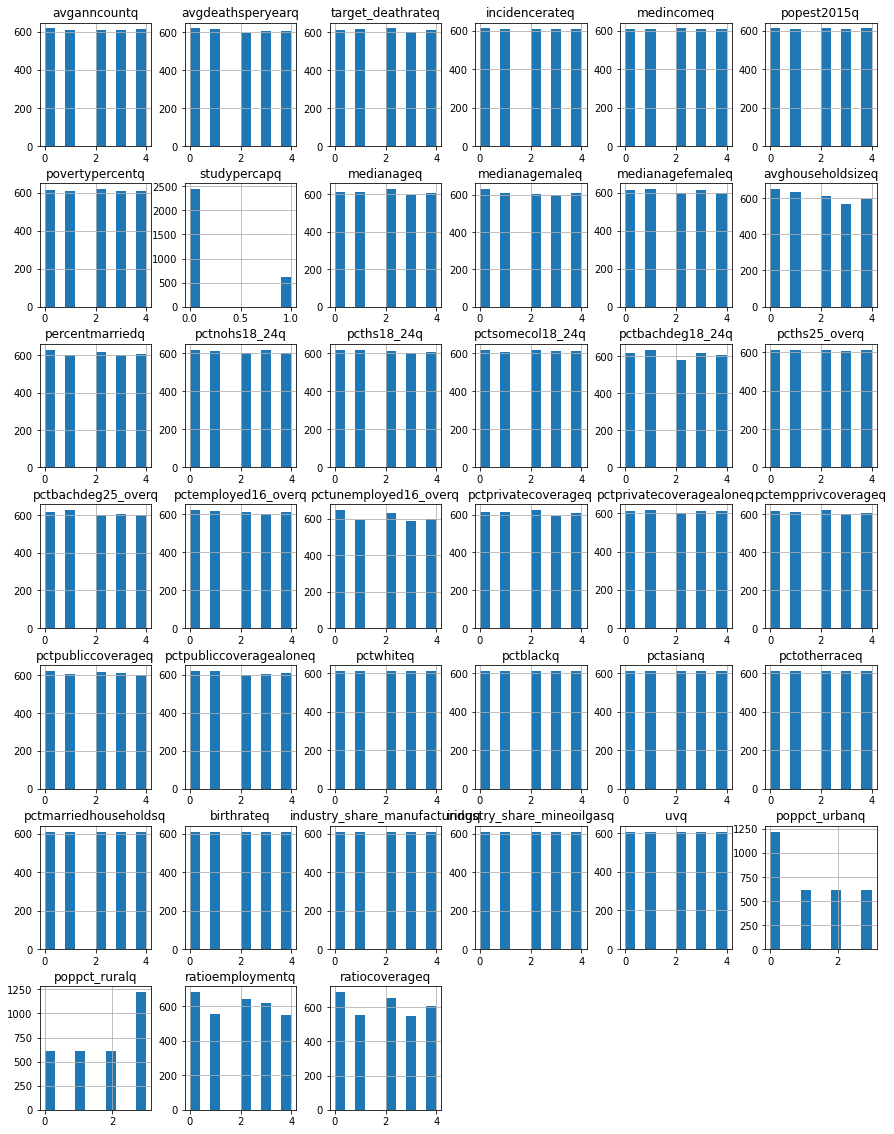

In [54]:
# Histogramms of the binned data
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
dfnum_bins.hist(ax = ax)

## 2.4 Outliers

In [55]:
# Move numericals to dedicated dataframe
numerical = data_main.select_dtypes('number')

### Checking for Outliers

In [56]:
Q1 = numerical.quantile(0.25)
Q3 = numerical.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

avganncount                       443.000000
avgdeathsperyear                  121.000000
target_deathrate                   34.000000
incidencerate                      60.500000
medincome                       13626.000000
popest2015                      57176.000000
povertypercent                      8.300000
studypercap                        83.840677
medianage                           6.300000
medianagemale                       6.100000
medianagefemale                     6.200000
avghouseholdsize                    0.260000
percentmarried                      8.700000
pctnohs18_24                        9.900000
pcths18_24                         11.500000
pctsomecol18_24                    12.800000
pctbachdeg18_24                     5.100000
pcths25_over                        9.200000
pctbachdeg25_over                   6.700000
pctemployed16_over                 12.100000
pctunemployed16_over                4.200000
pctprivatecoverage                 14.900000
pctprivate

In [57]:
# counting outliers
((numerical < (Q1 - 1.5 * IQR)) | (numerical > (Q3 + 1.5 * IQR))).sum()

avganncount                     464
avgdeathsperyear                352
target_deathrate                 64
incidencerate                    93
medincome                       123
popest2015                      413
povertypercent                   69
studypercap                     505
medianage                        93
medianagemale                    92
medianagefemale                  78
avghouseholdsize                201
percentmarried                   68
pctnohs18_24                     69
pcths18_24                       52
pctsomecol18_24                 110
pctbachdeg18_24                  95
pcths25_over                     32
pctbachdeg25_over                83
pctemployed16_over               45
pctunemployed16_over             68
pctprivatecoverage               21
pctprivatecoveragealone           5
pctempprivcoverage                9
pctpubliccoverage                17
pctpubliccoveragealone           35
pctwhite                        174
pctblack                    

### Deleting Outliers from Dataframe

In [58]:
numerical_o = numerical[~((numerical < (Q1 - 3 * IQR)) |(numerical > (Q3 + 3 * IQR))).any(axis=1)]
print(numerical.shape)
print(numerical_o.shape)

(3053, 39)
(1577, 39)


In [59]:
# check
numerical_o.describe()

,avganncount,avgdeathsperyear,target_deathrate,incidencerate,medincome,popest2015,povertypercent,studypercap,medianage,medianagemale,...,pctotherrace,pctmarriedhouseholds,birthrate,industry_share_manufacturing,industry_share_mineoilgas,uv,poppct_urban,poppct_rural,ratioemployment,ratiocoverage
count,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000,...,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000,1572.000000,1577.000000,1577.000000,1577.000000,1577.000000
mean,222.107166,89.548510,181.508941,450.037096,45763.245403,41745.293595,16.662080,28.184130,41.744325,40.512682,...,1.200152,52.473082,5.515271,16.230627,0.868549,4240.516750,35.106240,64.893767,7.406601,1.177785
std,223.858983,85.654714,26.075676,49.409672,10104.047827,44250.262953,5.568417,65.210079,4.893795,4.938338,...,1.429829,5.321378,1.741966,13.609545,1.512604,360.534173,26.374131,26.374126,3.155476,0.058179
min,9.000000,3.000000,80.800000,259.000000,23047.000000,1358.000000,4.300000,0.000000,22.300000,22.400000,...,0.000000,30.507696,0.000000,0.000000,0.000000,3012.000000,0.000000,0.000000,3.791086,1.056429
25%,74.000000,32.000000,165.100000,420.400000,38504.000000,12682.000000,12.400000,0.000000,39.100000,37.700000,...,0.254615,49.221790,4.451141,5.442651,0.010385,3982.250000,11.070000,44.490000,5.207784,1.140009
50%,143.000000,60.000000,181.600000,455.100000,44109.000000,25653.000000,16.100000,0.000000,41.700000,40.300000,...,0.660907,52.372139,5.354924,13.848763,0.210525,4223.000000,34.940000,65.060000,7.025973,1.175327
75%,275.000000,113.000000,198.100000,483.400000,51221.000000,51540.000000,20.100000,9.606979,44.400000,43.100000,...,1.593011,55.733524,6.422857,23.686488,0.892914,4485.000000,55.510000,88.930000,7.808807,1.196714
max,1385.000000,509.000000,292.500000,639.700000,92647.000000,235429.000000,45.100000,335.181127,59.000000,60.200000,...,7.802114,78.075397,12.146423,70.276519,7.243187,5723.000000,100.000000,100.000000,17.912889,1.324858


# 3. Data Exploring

## 3.1 Check for correlations

In [60]:
# calculate new Dataframe with correllation factors
corr_df = numerical.corr().abs()
corr_df

,avganncount,avgdeathsperyear,target_deathrate,incidencerate,medincome,popest2015,povertypercent,studypercap,medianage,medianagemale,...,pctotherrace,pctmarriedhouseholds,birthrate,industry_share_manufacturing,industry_share_mineoilgas,uv,poppct_urban,poppct_rural,ratioemployment,ratiocoverage
avganncount,1.000000,0.939918,0.144951,0.073584,0.273397,0.927175,0.138545,0.082352,0.024377,0.125670,...,0.208159,0.106485,0.035195,0.048441,0.086739,0.001416,0.382471,0.382471,0.004333,0.080947
avgdeathsperyear,0.939918,1.000000,0.092301,0.062896,0.227594,0.977339,0.070157,0.063840,0.024874,0.148995,...,0.213940,0.160399,0.074890,0.042282,0.090827,0.008356,0.421055,0.421055,0.116253,0.116152
target_deathrate,0.144951,0.092301,1.000000,0.449761,0.429781,0.122027,0.430162,0.022199,0.004520,0.021795,...,0.189849,0.293685,0.087195,0.176478,0.027988,0.072103,0.152400,0.152399,0.295772,0.247617
incidencerate,0.073584,0.062896,0.449761,1.000000,0.002983,0.026543,0.009644,0.077462,0.018113,0.014901,...,0.208821,0.152969,0.118056,0.168961,0.167899,0.309579,0.101255,0.101255,0.081164,0.177092
medincome,0.273397,0.227594,0.429781,0.002983,1.000000,0.241014,0.788096,0.043892,0.013641,0.092321,...,0.083946,0.444700,0.010885,0.050322,0.019435,0.171143,0.371444,0.371444,0.255651,0.014595
popest2015,0.927175,0.977339,0.122027,0.026543,0.241014,1.000000,0.068460,0.055993,0.025500,0.177156,...,0.240801,0.127573,0.058221,0.048173,0.079033,0.040640,0.393590,0.393590,0.098813,0.090328
povertypercent,0.138545,0.070157,0.430162,0.009644,0.788096,0.068460,1.000000,0.055694,0.029052,0.213342,...,0.047080,0.604123,0.011723,0.025705,0.000618,0.267619,0.141212,0.141212,0.414858,0.066160
studypercap,0.082352,0.063840,0.022199,0.077462,0.043892,0.055993,0.055694,1.000000,0.026040,0.036846,...,0.015193,0.051932,0.010474,0.009157,0.066220,0.069251,0.114714,0.114714,0.080641,0.009041
medianage,0.024377,0.024874,0.004520,0.018113,0.013641,0.025500,0.029052,0.026040,1.000000,0.129130,...,0.030274,0.014492,0.008260,0.014353,0.000167,0.025663,0.061148,0.061148,0.007175,0.032535
medianagemale,0.125670,0.148995,0.021795,0.014901,0.092321,0.177156,0.213342,0.036846,0.129130,1.000000,...,0.266810,0.222406,0.103784,0.062164,0.043833,0.212213,0.504433,0.504433,0.109727,0.072598


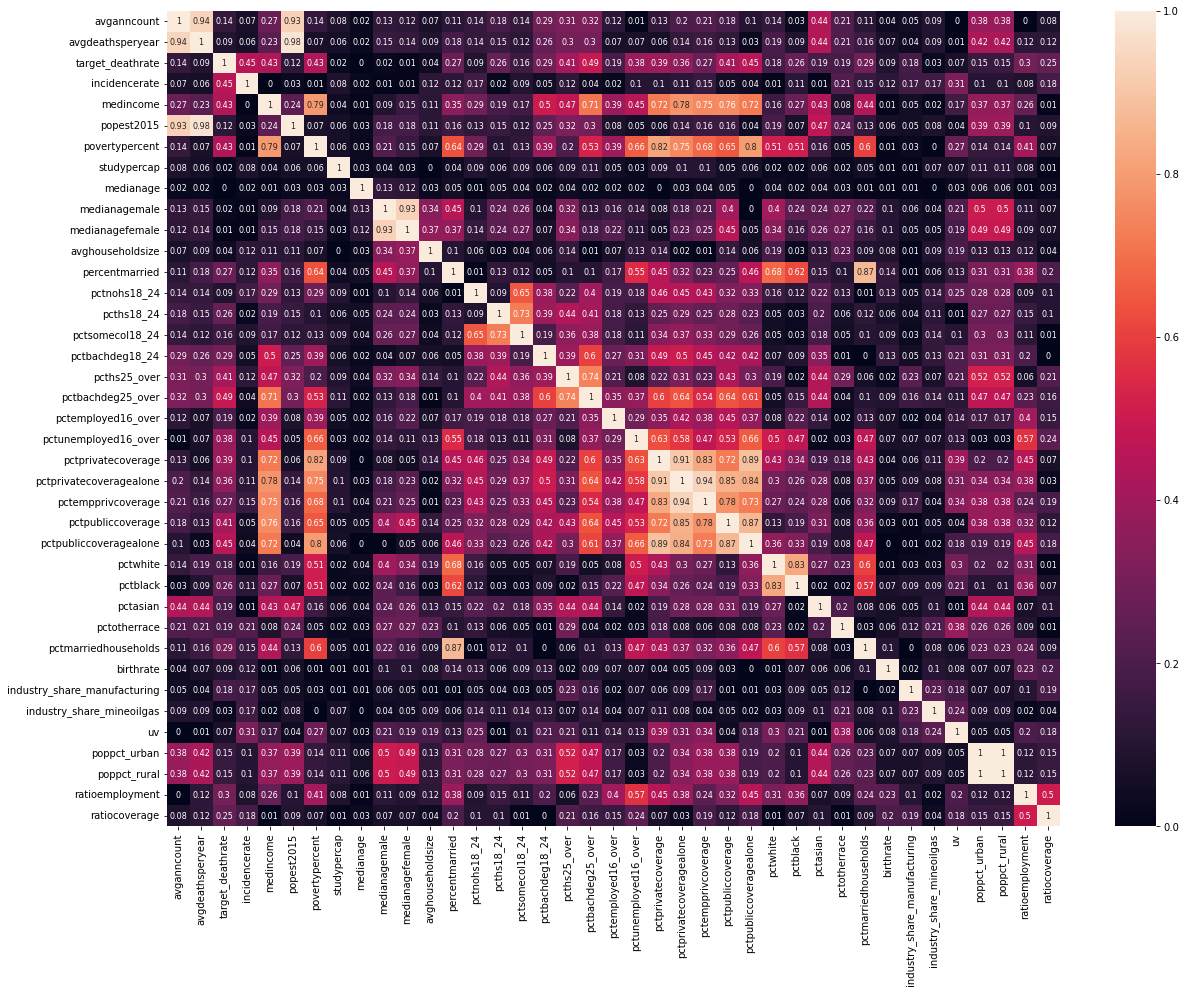

In [61]:
# Plot correlation heatmap
fig = plt.figure(figsize = (20,15))
ax = sns.heatmap(corr_df.round(2), annot=True, annot_kws={"size": 8})
plt.savefig('pics/corr_heatmap.png')

### Filtering out highly correlated features

In [62]:
# Select upper traingular
upper_tri = corr_df.where(np.triu(np.ones(corr_df.shape),k=1).astype(np.bool_))
# Save highly correlating features r>0.9 in the list to_drop
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]
# Drop the features from the to_drop list and create a reduced DataFrame
reduced_df = numerical.drop(numerical[to_drop], axis=1)

print("The reduced dataframe has {} columns.".format(reduced_df.shape[1]))

The reduced dataframe has 33 columns.


In [63]:
to_drop

['avgdeathsperyear',
 'popest2015',
 'medianagefemale',
 'pctprivatecoveragealone',
 'pctempprivcoverage',
 'poppct_rural']

## 3.1 Building graphs

### Histograms

C:\Users\flanc\AppData\Local\Temp/ipykernel_11800/3306283368.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  reduced_df.hist(ax = ax)


array([[<AxesSubplot:title={'center':'avganncount'}>,
        <AxesSubplot:title={'center':'target_deathrate'}>,
        <AxesSubplot:title={'center':'incidencerate'}>,
        <AxesSubplot:title={'center':'medincome'}>,
        <AxesSubplot:title={'center':'povertypercent'}>,
        <AxesSubplot:title={'center':'studypercap'}>],
       [<AxesSubplot:title={'center':'medianage'}>,
        <AxesSubplot:title={'center':'medianagemale'}>,
        <AxesSubplot:title={'center':'avghouseholdsize'}>,
        <AxesSubplot:title={'center':'percentmarried'}>,
        <AxesSubplot:title={'center':'pctnohs18_24'}>,
        <AxesSubplot:title={'center':'pcths18_24'}>],
       [<AxesSubplot:title={'center':'pctsomecol18_24'}>,
        <AxesSubplot:title={'center':'pctbachdeg18_24'}>,
        <AxesSubplot:title={'center':'pcths25_over'}>,
        <AxesSubplot:title={'center':'pctbachdeg25_over'}>,
        <AxesSubplot:title={'center':'pctemployed16_over'}>,
        <AxesSubplot:title={'center':'pctu

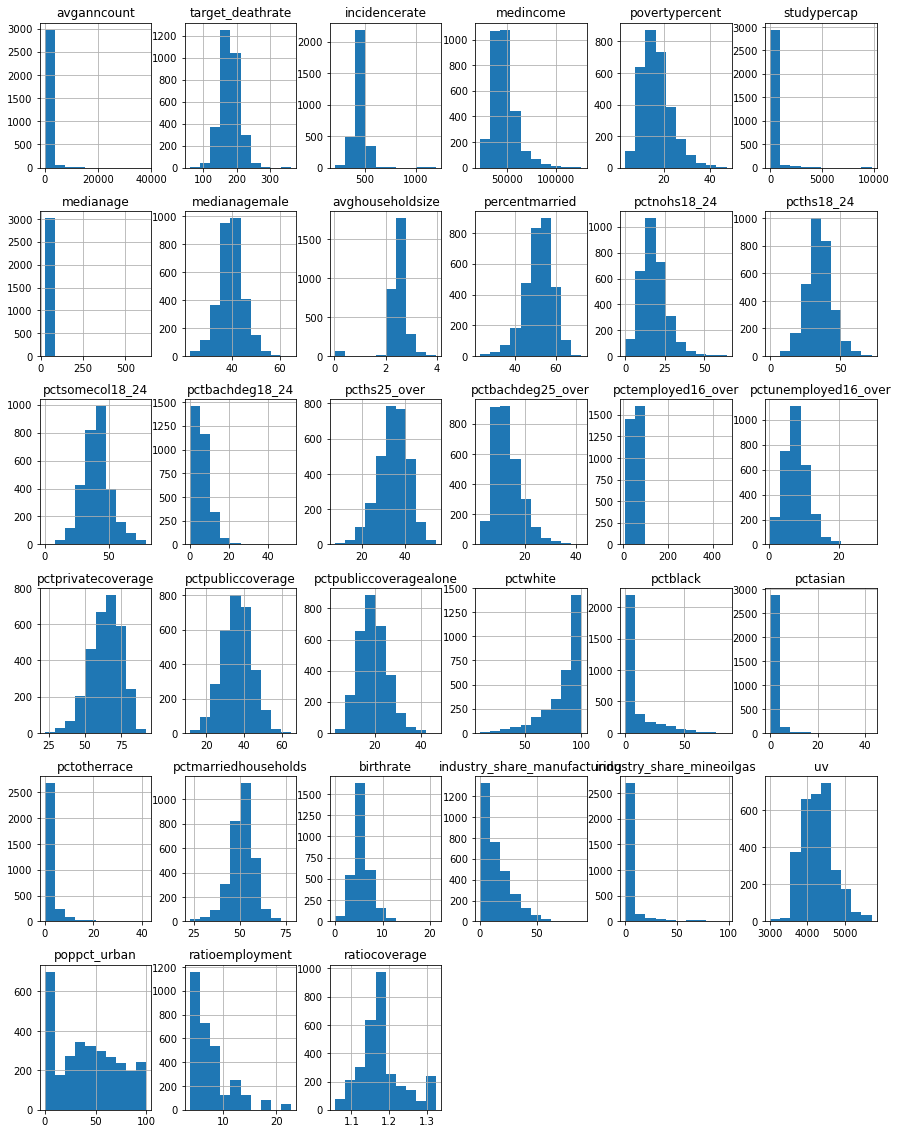

In [64]:
   fig = plt.figure(figsize = (15,20))
   ax = fig.gca()
   reduced_df.hist(ax = ax)

### Pairplots

In [65]:
# Pairplot for each numerical column
#sns.pairplot(numerical)

C:\Users\flanc\AppData\Local\Temp/ipykernel_11800/2562977361.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  numerical_o.hist(ax = ax)


array([[<AxesSubplot:title={'center':'avganncount'}>,
        <AxesSubplot:title={'center':'avgdeathsperyear'}>,
        <AxesSubplot:title={'center':'target_deathrate'}>,
        <AxesSubplot:title={'center':'incidencerate'}>,
        <AxesSubplot:title={'center':'medincome'}>,
        <AxesSubplot:title={'center':'popest2015'}>],
       [<AxesSubplot:title={'center':'povertypercent'}>,
        <AxesSubplot:title={'center':'studypercap'}>,
        <AxesSubplot:title={'center':'medianage'}>,
        <AxesSubplot:title={'center':'medianagemale'}>,
        <AxesSubplot:title={'center':'medianagefemale'}>,
        <AxesSubplot:title={'center':'avghouseholdsize'}>],
       [<AxesSubplot:title={'center':'percentmarried'}>,
        <AxesSubplot:title={'center':'pctnohs18_24'}>,
        <AxesSubplot:title={'center':'pcths18_24'}>,
        <AxesSubplot:title={'center':'pctsomecol18_24'}>,
        <AxesSubplot:title={'center':'pctbachdeg18_24'}>,
        <AxesSubplot:title={'center':'pcths25_ov

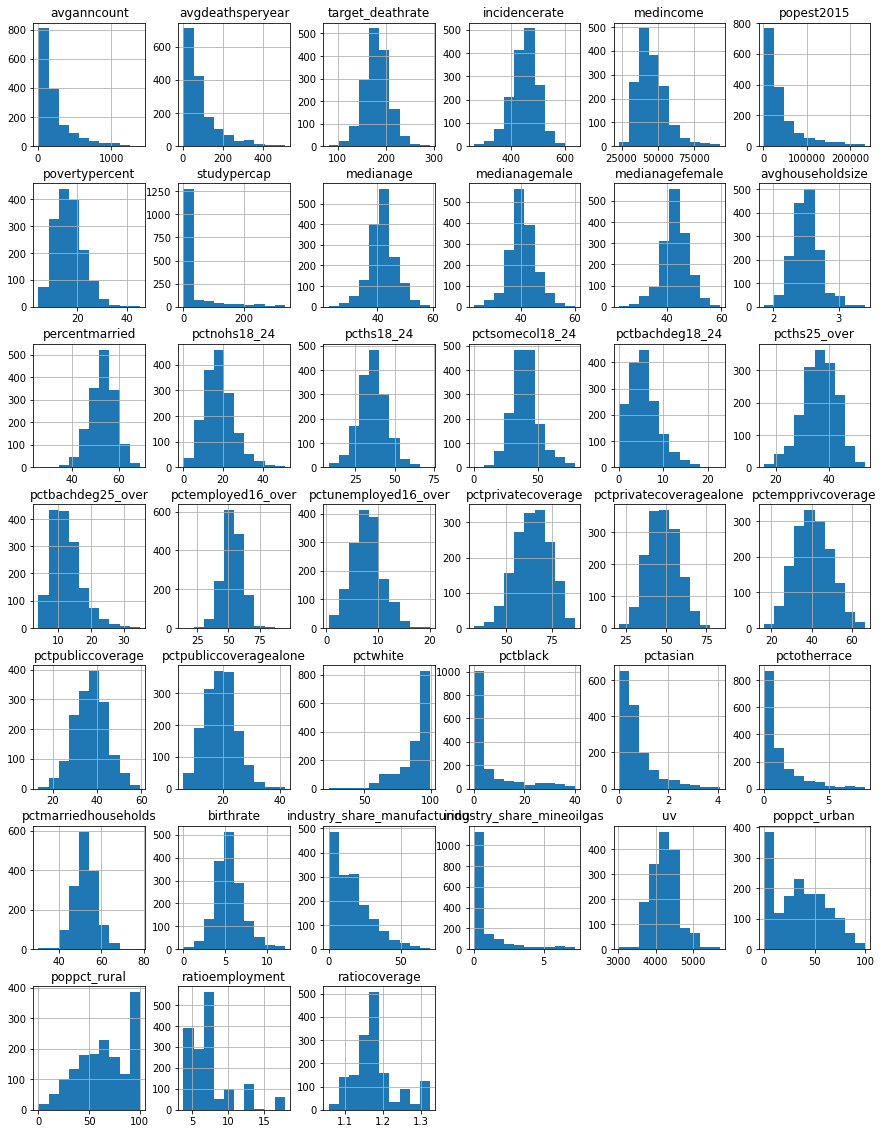

In [66]:
# check histogramms after loosing the outliers
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
numerical_o.hist(ax = ax)

In [67]:
# Fun fact - What are the most common county names
data_main['county'].value_counts().head(10)

Washington    31
Jefferson     26
Franklin      25
Lincoln       24
Jackson       22
Madison       20
Clay          18
Union         18
Montgomery    18
Monroe        17
Name: county, dtype: int64

# 4. Linear Regression Modelling

### Import Machine Learning Libraries

In [68]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

In [69]:
numerical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3053 entries, 0 to 3052
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   avganncount                   3053 non-null   float64
 1   avgdeathsperyear              3053 non-null   int64  
 2   target_deathrate              3053 non-null   float64
 3   incidencerate                 3053 non-null   float64
 4   medincome                     3053 non-null   int64  
 5   popest2015                    3053 non-null   int64  
 6   povertypercent                3053 non-null   float64
 7   studypercap                   3053 non-null   float64
 8   medianage                     3053 non-null   float64
 9   medianagemale                 3053 non-null   float64
 10  medianagefemale               3053 non-null   float64
 11  avghouseholdsize              3053 non-null   float64
 12  percentmarried                3053 non-null   float64
 13  pct

## 4.1 Model 1

### X-Y-Split

In [70]:
# Split-Up numerical into X and Y
X1_raw = numerical.drop(['target_deathrate','ratioemployment','ratiocoverage','uv'], axis=1)
Y1 = numerical['target_deathrate']

# Use Standard_Scaler
X1_array = StandardScaler().fit_transform(X1_raw)
X1 = pd.DataFrame(X1_array, index=X1_raw.index, columns=X1_raw.columns)

### Train-Test-Split

In [71]:
# train-test-split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, Y1, test_size=0.20, random_state=42)

### Linear Regression

In [72]:
# set model to Linear Regression
model1=LinearRegression()
# train the model
model1.fit(X1_train, y1_train)

LinearRegression()

### Prediction. plotting, Regression

In [73]:
y1_pred=model1.predict(X1_test)   # model prediction
y1_pred

result=pd.DataFrame({"y_test":y1_test,"y_pred":y1_pred})

Text(0.5, 1.0, 'Test Set Residual histogram')

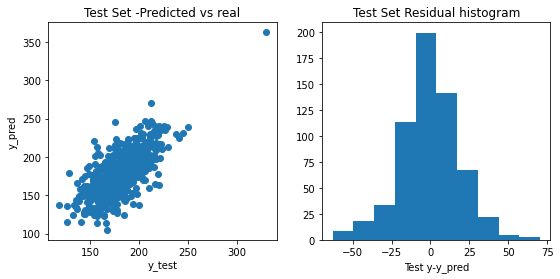

In [74]:
# Make an scatter plot y_pred vs y
# What kind of plot you will get if all the all the predictions are ok?
# A stright line

fig, ax = plt.subplots(1,2,figsize=(9,4))
ax[0].plot(y1_pred, y1_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
ax[1].hist(y1_test - y1_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

<AxesSubplot:xlabel='y_pred', ylabel='y_test'>

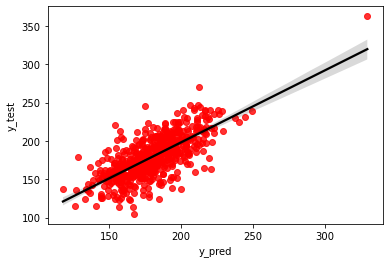

In [75]:
sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})

In [76]:
# Compute:
# ME: mean error
ME1 = np.mean( y1_test - y1_pred )

# MAE: mean absolute error
MAE1 = np.mean( np.abs( y1_test - y1_pred ) )

# MSE: mean squared error
MSE1 = np.mean( np.power( y1_test - y1_pred , 2 ) )

# RMSE: root mean squared error
RMSE1 = np.sqrt(MSE1)

# MAPE: mean absolute percentual error
MAPE1 = np.mean( np.abs( y1_test - y1_pred) / y1_test ) 

print('mean error: ' + str(round(ME1,2)))
print('mean absolute error: ' + str(round(MAE1,2)))
print('mean squared error: ' + str(round(MSE1,2)))
print('root mean squared error: ' + str(round(RMSE1,2)))
print('mean absolute percentual error: ' + str(round(MAPE1,2)))

mean error: -0.59
mean absolute error: 14.5
mean squared error: 368.68
root mean squared error: 19.2
mean absolute percentual error: 0.08


### Model Summary

In [77]:
# Sklearn overview
print('------ Lineare Regression -----')
print('Function from sklearn: y = %.3f * x + %.3f' % (model1.coef_[0], model1.intercept_))
print("Alpha: {}".format(model1.intercept_))
print("Beta: {}".format(model1.coef_[0]))
print("Training Set R² Score: {:.2f}".format(model1.score(X1_train, y1_train)))
print("Test Set R² Score: {:.2f}".format(model1.score(X1_test, y1_test)))
print("\n")

------ Lineare Regression -----
Function from sklearn: y = -4.918 * x + 178.745
Alpha: 178.74494902389077
Beta: -4.917683104653336
Training Set R² Score: 0.52
Test Set R² Score: 0.51




In [78]:
# Stats overview
import statsmodels.api as sm

X_train_const_scaled1 = sm.add_constant(X1_train) # adding a constant

model1_OLS = sm.OLS(y1_train, X_train_const_scaled1).fit()
predictions1 = model1_OLS.predict(X_train_const_scaled1) 

X_test_const_scaled1 = sm.add_constant(X1_test) # adding a constant
print_model1 = model1_OLS.summary()
print(print_model1)

                            OLS Regression Results                            
Dep. Variable:       target_deathrate   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     75.17
Date:                Fri, 19 Nov 2021   Prob (F-statistic):               0.00
Time:                        12:00:05   Log-Likelihood:                -10683.
No. Observations:                2442   AIC:                         2.144e+04
Df Residuals:                    2406   BIC:                         2.165e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

C:\Users\flanc\.conda\envs\iron\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<BarContainer object of 35 artists>

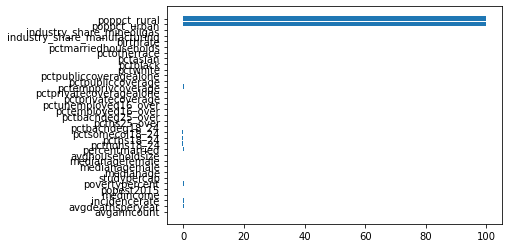

In [79]:
# get coefficient
intercept = model1.intercept_
features = pd.DataFrame(model1.coef_, X1.columns, columns=['coefficient'])
# get standard deviation
stdevs = []
for i in X1.columns:
    stdev = X1[i].std()
    stdevs.append(stdev)
 
features["stdev"] = np.array(stdevs).reshape(-1,1)
features["importance"] = features["coefficient"] * features["stdev"]
features['importance_normalized'] = 100*features['importance'] / features['importance'].max()
plt.barh(features.index, features.importance_normalized)

## 4.2 Model 2

### X-Y-Split

In [80]:
# Split-Up numerical into X and Y
X2_raw = reduced_df.drop(['target_deathrate','ratioemployment','ratiocoverage','uv'], axis=1)
Y2 = reduced_df['target_deathrate']

# Use Standard_Scaler
X2_array = StandardScaler().fit_transform(X2_raw)
X2 = pd.DataFrame(X2_array, index=X2_raw.index, columns=X2_raw.columns)

### Train-Test-Split

In [81]:
# train-test-split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, Y2, test_size=0.20, random_state=42)

### Linear Regression

In [82]:
# set model to Linear Regression
model2=LinearRegression()
# train the model
model2.fit(X2_train, y2_train)

LinearRegression()

### Prediction, Plotting, metrics

In [83]:
y2_pred=model2.predict(X2_test)   # model prediction
y2_pred

result2=pd.DataFrame({"y_test":y2_test,"y_pred":y2_pred})

Text(0.5, 1.0, 'Test Set Residual histogram')

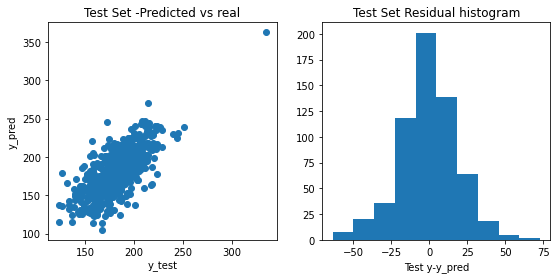

In [84]:
# Make an scatter plot y_pred vs y
# What kind of plot you will get if all the all the predictions are ok?
# A stright line

fig, ax = plt.subplots(1,2,figsize=(9,4))
ax[0].plot(y2_pred, y2_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
ax[1].hist(y2_test - y2_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

<AxesSubplot:xlabel='y_pred', ylabel='y_test'>

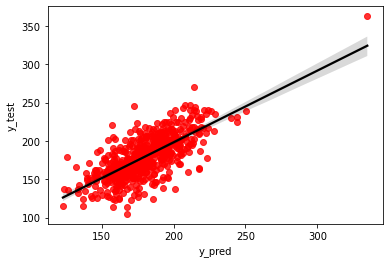

In [85]:
sns.regplot(x='y_pred',y='y_test', data=result2, scatter_kws={"color": "red"}, line_kws={"color": "black"})

In [86]:
# Compute:
# ME: mean error
ME2 = np.mean( y2_test - y2_pred )

# MAE: mean absolute error
MAE2 = np.mean( np.abs( y2_test - y2_pred ) )

# MSE: mean squared error
MSE2 = np.mean( np.power( y2_test - y2_pred , 2 ) )

# RMSE: root mean squared error
RMSE2 = np.sqrt(MSE2)

# MAPE: mean absolute percentual error
MAPE2 = np.mean( np.abs( y2_test - y2_pred) / y2_test ) 

print('mean error: ' + str(round(ME2,2)))
print('mean absolute error: ' + str(round(MAE2,2)))
print('mean squared error: ' + str(round(MSE2,2)))
print('root mean squared error: ' + str(round(RMSE2,2)))
print('mean absolute percentual error: ' + str(round(MAPE2,2)))

mean error: -0.57
mean absolute error: 14.57
mean squared error: 372.3
root mean squared error: 19.29
mean absolute percentual error: 0.08


### Model Summary

In [87]:
# Sklearn overview
print('------ Lineare Regression -----')
print('Function from sklearn: y = %.3f * x + %.3f' % (model2.coef_[0], model2.intercept_))
print("Alpha: {}".format(model2.intercept_))
print("Beta: {}".format(model2.coef_[0]))
print("Training Set R² Score: {:.2f}".format(model2.score(X2_train, y2_train)))
print("Test Set R² Score: {:.2f}".format(model2.score(X2_test, y2_test)))
print("\n")

------ Lineare Regression -----
Function from sklearn: y = -0.666 * x + 178.742
Alpha: 178.74159633663038
Beta: -0.6661784138640019
Training Set R² Score: 0.51
Test Set R² Score: 0.51




In [88]:
# Stats overview
X_train_const_scaled2 = sm.add_constant(X2_train) # adding a constant

model2_OLS = sm.OLS(y2_train, X_train_const_scaled2).fit()
predictions2 = model2_OLS.predict(X_train_const_scaled2) 

X_test_const_scaled2 = sm.add_constant(X2_test) # adding a constant
print_model2 = model2_OLS.summary()
print(print_model2)

                            OLS Regression Results                            
Dep. Variable:       target_deathrate   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     87.94
Date:                Fri, 19 Nov 2021   Prob (F-statistic):               0.00
Time:                        12:00:07   Log-Likelihood:                -10704.
No. Observations:                2442   AIC:                         2.147e+04
Df Residuals:                    2412   BIC:                         2.164e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

C:\Users\flanc\.conda\envs\iron\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<BarContainer object of 29 artists>

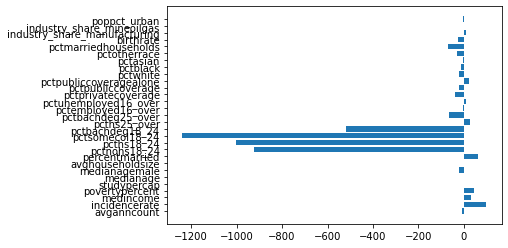

In [89]:
# get coefficient
intercept = model2.intercept_
features = pd.DataFrame(model2.coef_, X2.columns, columns=['coefficient'])
# get standard deviation
stdevs = []
for i in X2.columns:
    stdev = X2[i].std()
    stdevs.append(stdev)
 
features["stdev"] = np.array(stdevs).reshape(-1,1)
features["importance"] = features["coefficient"] * features["stdev"]
features['importance_normalized'] = 100*features['importance'] / features['importance'].max()
plt.barh(features.index, features.importance_normalized)

## 4.3 Model 3

### Exclude highly correlating features

In [90]:
# building correlation matrix
corr_df3 = numerical_o.corr
# Select upper traingular
upper_tri = corr_df.where(np.triu(np.ones(corr_df.shape),k=1).astype(np.bool_))
# Save highly correlating features r>0.9 in the list to_drop
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]
# Drop the features from the to_drop list and create a reduced DataFrame
df3 = numerical_o.drop(numerical[to_drop], axis=1)

print("The reduced dataframe has {} columns.".format(df3.shape[1]))

The reduced dataframe has 33 columns.


In [91]:
to_drop

['avgdeathsperyear',
 'popest2015',
 'medianagefemale',
 'pctprivatecoveragealone',
 'pctempprivcoverage',
 'poppct_rural']

### X-Y-Split

In [92]:
# Split-Up numerical into X and Y
X3_raw = numerical_o.drop(['target_deathrate','ratioemployment','ratiocoverage','uv'], axis=1)
Y3 = numerical_o['target_deathrate']

# Use Standard_Scaler
X3_array = StandardScaler().fit_transform(X3_raw)
X3 = pd.DataFrame(X3_array, index=X3_raw.index, columns=X3_raw.columns)

### Train-Test-Split

In [93]:
# train-test-split
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, Y3, test_size=0.20, random_state=42)

### Linear Regression

In [94]:
# set model to Linear Regression
model3=LinearRegression()
# train the model
model3.fit(X3_train, y3_train)

LinearRegression()

### Prediction, plotting, metrics

In [95]:
y3_pred=model3.predict(X3_test)   # model prediction
y3_pred

result3=pd.DataFrame({"y_test":y3_test,"y_pred":y3_pred})

Text(0.5, 1.0, 'Test Set Residual histogram')

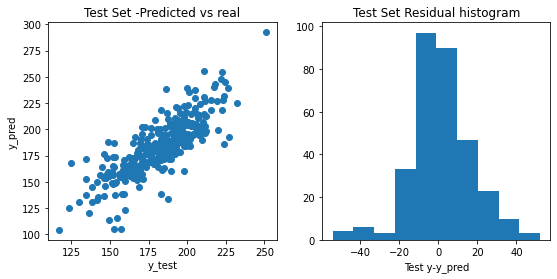

In [96]:
# Make an scatter plot y_pred vs y
# What kind of plot you will get if all the all the predictions are ok?
# A stright line

fig, ax = plt.subplots(1,2,figsize=(9,4))
ax[0].plot(y3_pred, y3_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
ax[1].hist(y3_test - y3_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

<AxesSubplot:xlabel='y_pred', ylabel='y_test'>

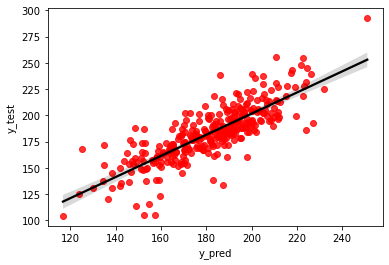

In [97]:
sns.regplot(x='y_pred',y='y_test', data=result3, scatter_kws={"color": "red"}, line_kws={"color": "black"})

In [98]:
# Compute:
# ME: mean error
ME3 = np.mean( y3_test - y3_pred )

# MAE: mean absolute error
MAE3 = np.mean( np.abs( y3_test - y3_pred ) )

# MSE: mean squared error
MSE3 = np.mean( np.power( y3_test - y3_pred , 2 ) )

# RMSE: root mean squared error
RMSE3 = np.sqrt(MSE3)

# MAPE: mean absolute percentual error
MAPE3 = np.mean( np.abs( y3_test - y3_pred) / y3_test ) 

print('mean error: ' + str(round(ME3,2)))
print('mean absolute error: ' + str(round(MAE3,2)))
print('mean squared error: ' + str(round(MSE3,2)))
print('root mean squared error: ' + str(round(RMSE3,2)))
print('mean absolute percentual error: ' + str(round(MAPE3,2)))

mean error: 1.53
mean absolute error: 11.7
mean squared error: 247.09
root mean squared error: 15.72
mean absolute percentual error: 0.07


### Model Summary

In [99]:
# Sklearn overview
print('------ Lineare Regression -----')
print('Function from sklearn: y = %.3f * x + %.3f' % (model3.coef_[0], model3.intercept_))
print("Alpha: {}".format(model3.intercept_))
print("Beta: {}".format(model3.coef_[0]))
print("Training Set R² Score: {:.2f}".format(model3.score(X3_train, y3_train)))
print("Test Set R² Score: {:.2f}".format(model3.score(X3_test, y3_test)))
print("\n")

------ Lineare Regression -----
Function from sklearn: y = -81.402 * x + 181.201
Alpha: 181.2014562468137
Beta: -81.40187617073398
Training Set R² Score: 0.66
Test Set R² Score: 0.66




In [100]:
# Stats overview
X_train_const_scaled3 = sm.add_constant(X3_train) # adding a constant

model3_OLS = sm.OLS(y3_train, X_train_const_scaled3).fit()
predictions3 = model3_OLS.predict(X_train_const_scaled3) 

X_test_const_scaled3 = sm.add_constant(X3_test) # adding a constant
print_model3 = model3_OLS.summary()
print_model3

C:\Users\flanc\.conda\envs\iron\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       target_deathrate   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     68.62
Date:                Fri, 19 Nov 2021   Prob (F-statistic):          5.39e-256
Time:                        12:00:09   Log-Likelihood:                -5219.3
No. Observations:                1261   AIC:                         1.051e+04
Df Residuals:                    1226   BIC:                         1.069e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                          181.2015      0.435    416.936      0.000     180.349     182.054
avganncount                    -81.4019      4.377    -18.597      0.000     -89.989     -72.815
avgdeathsperyear                71.1887      3.662     19.441      0.000      64.005      78.373
incidencerate                   12.0992      0.550     21.982      0.000      11.019      13.179
medincome                        5.5167      1.283      4.300      0.000       3.000       8.034
popest2015                       9.9196      2.127      4.663      0.000       5.746      14.093
povertypercent                   5.9893      1.219      4.913      0.000       3.598       8.381
studypercap                      0.2688      0.483      0.557      0.578      -0.679       1.216
medianage                        7.3099      7.346      0.995      0.320      -7.102      21.722
medianagemale                   -6.9163      4.245     -1.629      0.104     -15.245       1.412
medianagefemale                 -0.8629      3.809     -0.227      0.821      -8.336       6.611
avghouseholdsize                -1.1095      1.005     -1.104      0.270      -3.081       0.862
percentmarried                   0.0965      1.368      0.071      0.944      -2.588       2.781
pctnohs18_24                  -151.3904    109.769     -1.379      0.168    -366.746      63.965
pcths18_24                    -175.4530    128.885     -1.361      0.174    -428.312      77.406
pctsomecol18_24               -215.9924    156.681     -1.379      0.168    -523.386      91.401
pctbachdeg18_24                -69.1203     50.416     -1.371      0.171    -168.031      29.790
pcths25_over                     2.0168      0.832      2.425      0.015       0.385       3.649
pctbachdeg25_over               -4.4509      1.013     -4.394      0.000      -6.438      -2.464
pctemployed16_over              -1.3471      0.702     -1.918      0.055      -2.725       0.031
pctunemployed16_over             1.5938      0.672      2.371      0.018       0.275       2.912
pctprivatecoverage              -2.5167      2.250     -1.119      0.263      -6.930       1.897
pctprivatecoveragealone         -3.0020      2.345     -1.280      0.201      -7.603       1.599
pctempprivcoverage               2.6597      1.434      1.854      0.064      -0.154       5.474
pctpubliccoverage               -4.4853      2.278     -1.969      0.049      -8.955      -0.015
pctpubliccoveragealone           3.9508      2.124      1.860      0.063      -0.216       8.118
pctwhite                        -0.3935      0.995     -0.396      0.692      -2.345       1.558
pctblack                        -0.2777      0.910     -0.305      0.760      -2.063       1.508
pctasian                         0.7977      0.603      1.323      0.186    

<BarContainer object of 35 artists>

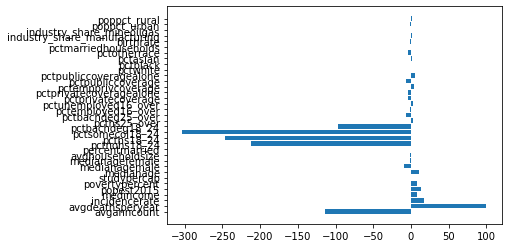

In [101]:
# get coefficient
intercept = model3.intercept_
features = pd.DataFrame(model3.coef_, X3.columns, columns=['coefficient'])
# get standard deviation
stdevs = []
for i in X3.columns:
    stdev = X3[i].std()
    stdevs.append(stdev)
 
features["stdev"] = np.array(stdevs).reshape(-1,1)
features["importance"] = features["coefficient"] * features["stdev"]
features['importance_normalized'] = 100*features['importance'] / features['importance'].max()
plt.barh(features.index, features.importance_normalized)

In [102]:
features.to_csv('features_importance_model3.csv')

## 4.4 Model 4

### X-Y-Split

In [103]:
# Split-Up numerical into X and Y
X4_raw = numerical_o[['avganncount','avgdeathsperyear','incidencerate','medincome','popest2015','povertypercent','pctbachdeg25_over','pctemployed16_over','pctunemployed16_over','pctempprivcoverage','pctpubliccoverage','pctpubliccoveragealone','pctotherrace','birthrate']]
Y4 = numerical_o['target_deathrate']

# Use Standard_Scaler
X4_array = StandardScaler().fit_transform(X4_raw)
X4 = pd.DataFrame(X4_array, index=X4_raw.index, columns=X4_raw.columns)

### Train-Test-Split

In [104]:
# train-test-split
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, Y4, test_size=0.20, random_state=42)

### Linear Regression

In [105]:
# set model to Linear Regression
model4=LinearRegression()
# train the model
model4.fit(X4_train, y4_train)

LinearRegression()

### Prediction, plotting, metrics

In [106]:
y4_pred=model4.predict(X4_test)   # model prediction
y4_pred

result4=pd.DataFrame({"y_test":y4_test,"y_pred":y4_pred})

Text(0.5, 1.0, 'Test Set Residual histogram')

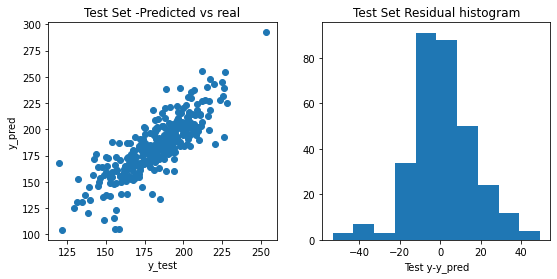

In [107]:
# Make an scatter plot y_pred vs y
# What kind of plot you will get if all the all the predictions are ok?
# A stright line

fig, ax = plt.subplots(1,2,figsize=(9,4))
ax[0].plot(y4_pred, y4_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
ax[1].hist(y4_test - y4_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

<AxesSubplot:xlabel='y_pred', ylabel='y_test'>

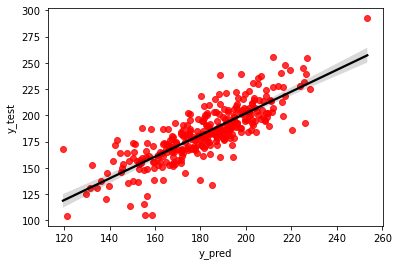

In [108]:
sns.regplot(x='y_pred',y='y_test', data=result4, scatter_kws={"color": "red"}, line_kws={"color": "black"})

In [109]:
# Compute:
# ME: mean error
ME4 = np.mean( y4_test - y4_pred )

# MAE: mean absolute error
MAE4 = np.mean( np.abs( y4_test - y4_pred ) )

# MSE: mean squared error
MSE4 = np.mean( np.power( y4_test - y4_pred , 2 ) )

# RMSE: root mean squared error
RMSE4 = np.sqrt(MSE4)

# MAPE: mean absolute percentual error
MAPE4 = np.mean( np.abs( y4_test - y4_pred) / y4_test ) 

print('mean error: ' + str(round(ME4,2)))
print('mean absolute error: ' + str(round(MAE4,2)))
print('mean squared error: ' + str(round(MSE4,2)))
print('root mean squared error: ' + str(round(RMSE4,2)))
print('mean absolute percentual error: ' + str(round(MAPE4,2)))

mean error: 1.39
mean absolute error: 11.67
mean squared error: 244.34
root mean squared error: 15.63
mean absolute percentual error: 0.07


### Model Summary

In [110]:
# Sklearn overview
print('------ Lineare Regression -----')
print('Function from sklearn: y = %.3f * x + %.3f' % (model4.coef_[0], model4.intercept_))
print("Alpha: {}".format(model4.intercept_))
print("Beta: {}".format(model4.coef_[0]))
print("Training Set R² Score: {:.2f}".format(model4.score(X4_train, y4_train)))
print("Test Set R² Score: {:.2f}".format(model4.score(X4_test, y4_test)))
print("\n")

------ Lineare Regression -----
Function from sklearn: y = -81.551 * x + 181.231
Alpha: 181.23131763643906
Beta: -81.55105950726629
Training Set R² Score: 0.64
Test Set R² Score: 0.66




In [111]:
# Stats overview
X_train_const_scaled4 = sm.add_constant(X4_train) # adding a constant

model4_OLS = sm.OLS(y4_train, X_train_const_scaled4).fit()
predictions4 = model4_OLS.predict(X_train_const_scaled4) 

X_test_const_scaled4 = sm.add_constant(X4_test) # adding a constant
print_model4 = model4_OLS.summary()
print_model4

C:\Users\flanc\.conda\envs\iron\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       target_deathrate   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     157.5
Date:                Fri, 19 Nov 2021   Prob (F-statistic):          1.48e-263
Time:                        12:00:10   Log-Likelihood:                -5249.0
No. Observations:                1261   AIC:                         1.053e+04
Df Residuals:                    1246   BIC:                         1.061e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    181.2313      0.441    411.096      0.000     180.366     182.096
avganncount              -81.5511      4.242    -19.224      0.000     -89.873     -73.229
avgdeathsperyear          72.6744      3.554     20.448      0.000      65.702      79.647
incidencerate             12.2172      0.525     23.281      0.000      11.188      13.247
medincome                  4.5150      1.111      4.064      0.000       2.336       6.695
popest2015                 8.2997      2.013      4.124      0.000       4.351      12.248
povertypercent             5.2578      1.078      4.877      0.000       3.143       7.373
pctbachdeg25_over         -6.8146      0.706     -9.651      0.000      -8.200      -5.429
pctemployed16_over        -1.4822      0.649     -2.285      0.022      -2.755      -0.210
pctunemployed16_over       1.4585      0.619      2.355      0.019       0.243       2.674
pctempprivcoverage         0.2427      0.822      0.295      0.768      -1.371       1.856
pctpubliccoverage         -4.1738      1.273     -3.279      0.001      -6.671      -1.677
pctpubliccoveragealone     5.9517      1.204      4.943      0.000       3.589       8.314
pctotherrace              -2.6415      0.489     -5.397      0.000      -3.602      -1.681
birthrate                 -1.2347      0.462     -2.675      0.008      -2.140      -0.329
==============================================================================
Omnibus:                       30.188   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.337
Skew:                           0.151   Prob(JB):                     9.63e-13
Kurtosis:                       3.981   Cond. No.                         29.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [112]:
from sklearn.model_selection import cross_val_score

scores1 = cross_val_score(model4,X=X4_train,y=y4_train, cv=10)
print ('Cross-validated scores:', scores1)
print('score_mean',scores1.mean(),': score_std',scores1.std())

Cross-validated scores: [0.67960904 0.68537217 0.70938194 0.44943232 0.59545682 0.67877206
 0.63383554 0.48003163 0.59427671 0.56506764]
score_mean 0.6071235884885986 : score_std 0.08412463594454388


<BarContainer object of 14 artists>

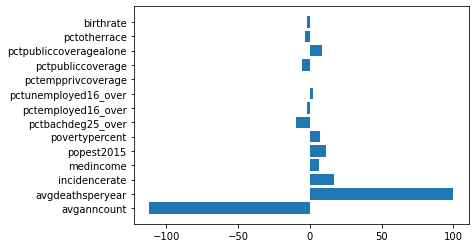

In [113]:
# get coefficient
intercept = model4.intercept_
features = pd.DataFrame(model4.coef_, X4.columns, columns=['coefficient'])
# get standard deviation
stdevs = []
for i in X4.columns:
    stdev = X4[i].std()
    stdevs.append(stdev)
 
features["stdev"] = np.array(stdevs).reshape(-1,1)
features["importance"] = features["coefficient"] * features["stdev"]
features['importance_normalized'] = 100*features['importance'] / features['importance'].max()
plt.barh(features.index, features.importance_normalized)

## 4.5 Model 6

### X-Y-Split

In [114]:
# Split-Up numerical into X and Y
X = dfnum_bins.drop(['target_deathrateq','uvq','ratioemploymentq','ratiocoverageq'], axis=1)
Y = dfnum['target_deathrate']

### Train-Test-Split

In [115]:
# train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

### Linear Regression

In [116]:
# set model to Linear Regression
model=LinearRegression()
# train the model
model.fit(X_train, y_train)

LinearRegression()

### Prediction, Plotting, Metrics

In [117]:
y_pred=model.predict(X_test)   # model prediction
y_pred

result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

Text(0.5, 1.0, 'Test Set Residual histogram')

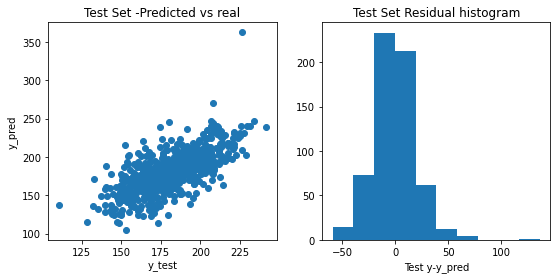

In [118]:
# Make an scatter plot y_pred vs y
# What kind of plot you will get if all the all the predictions are ok?
# A stright line

fig, ax = plt.subplots(1,2,figsize=(9,4))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

<AxesSubplot:xlabel='y_pred', ylabel='y_test'>

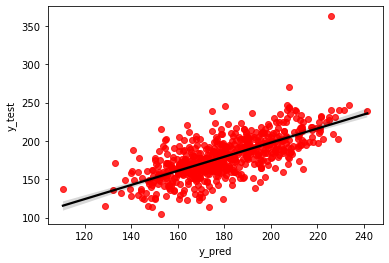

In [119]:
sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})

In [120]:
# Compute:
# ME: mean error
ME = np.mean( y_test - y_pred )

# MAE: mean absolute error
MAE = np.mean( np.abs( y_test - y_pred ) )

# MSE: mean squared error
MSE = np.mean( np.power( y_test - y_pred , 2 ) )

# RMSE: root mean squared error
RMSE = np.sqrt(MSE)

# MAPE: mean absolute percentual error
MAPE = np.mean( np.abs( y_test - y_pred) / y_test ) 

print('mean error: ' + str(round(ME,2)))
print('mean absolute error: ' + str(round(MAE,2)))
print('mean squared error: ' + str(round(MSE,2)))
print('root mean squared error: ' + str(round(RMSE,2)))
print('mean absolute percentual error: ' + str(round(MAPE,2)))

mean error: -0.55
mean absolute error: 14.85
mean squared error: 397.14
root mean squared error: 19.93
mean absolute percentual error: 0.09


### Model Summary

In [121]:
# Sklearn overview
print('------ Lineare Regression -----')
print('Function from sklearn: y = %.3f * x + %.3f' % (model.coef_[0], model.intercept_))
print("Alpha: {}".format(model.intercept_))
print("Beta: {}".format(model.coef_[0]))
print("Training Set R² Score: {:.2f}".format(model.score(X_train, y_train)))
print("Test Set R² Score: {:.2f}".format(model.score(X_test, y_test)))
print("\n")

------ Lineare Regression -----
Function from sklearn: y = -1.609 * x + 180.449
Alpha: 180.4487295508943
Beta: -1.6089113898800624
Training Set R² Score: 0.52
Test Set R² Score: 0.47




In [122]:
# Stats overview
X_train_const_scaled = sm.add_constant(X_train) # adding a constant

model_OLS = sm.OLS(y_train, X_train_const_scaled).fit()
predictions = model_OLS.predict(X_train_const_scaled) 

X_test_const_scaled = sm.add_constant(X_test) # adding a constant
print_model = model_OLS.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:       target_deathrate   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     78.16
Date:                Fri, 19 Nov 2021   Prob (F-statistic):               0.00
Time:                        12:00:11   Log-Likelihood:                -10677.
No. Observations:                2442   AIC:                         2.142e+04
Df Residuals:                    2407   BIC:                         2.163e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

C:\Users\flanc\.conda\envs\iron\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<BarContainer object of 35 artists>

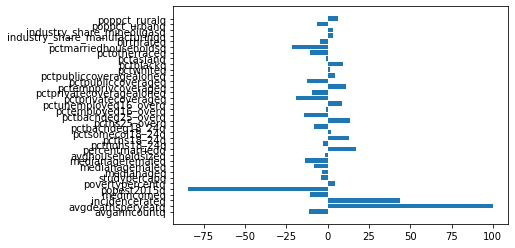

In [123]:
# get coefficient
intercept = model.intercept_
features = pd.DataFrame(model.coef_, X.columns, columns=['coefficient'])
# get standard deviation
stdevs = []
for i in X.columns:
    stdev = X[i].std()
    stdevs.append(stdev)
 
features["stdev"] = np.array(stdevs).reshape(-1,1)
features["importance"] = features["coefficient"] * features["stdev"]
features['importance_normalized'] = 100*features['importance'] / features['importance'].max()
plt.barh(features.index, features.importance_normalized)

## Random Forest

### Model 5

Training set score: 0.94
Test set score: 0.40


Text(0.5, 1.0, 'Test Set Residual histogram')

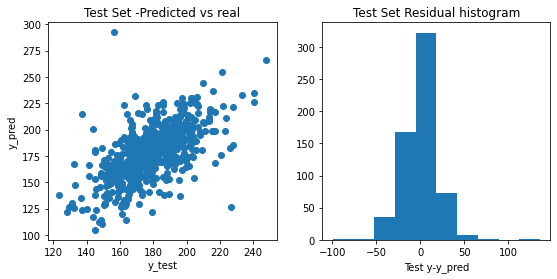

In [124]:
from sklearn.ensemble import RandomForestRegressor

# Split-Up numerical into X and Y
X5 = numerical.drop(['target_deathrate','ratioemployment','ratiocoverage','uv'], axis=1)
Y5 = numerical['target_deathrate']

# train-test-split
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, Y5, test_size=0.20)

# Train Random Forest
rf5 = RandomForestRegressor(n_estimators=100)
rf5.fit(X5_train, y5_train)

y5_pred=rf5.predict(X5_test)   # model prediction
result=pd.DataFrame({"y_test":y5_test,"y_pred":y5_pred})


print("Training set score: {:.2f}".format(rf5.score(X5_train, y5_train)))
print("Test set score: {:.2f}".format(rf5.score(X5_test, y5_test)))

#fig = plt.figure()
#ax = fig.add_subplot(111)

#ax.errorbar(y5_test, y5_pred, fmt='o')
#ax.errorbar([1, y5_test.max()], [1, y5_test.max()])
fig, ax = plt.subplots(1,2,figsize=(9,4))
ax[0].plot(y5_pred, y5_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
ax[1].hist(y5_test - y5_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

<AxesSubplot:xlabel='y_pred', ylabel='y_test'>

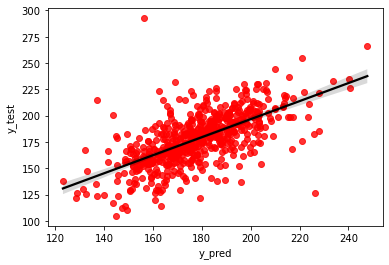

In [125]:
sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})

### Error Metrics

In [126]:
# Compute:
# ME: mean error
ME = np.mean( y5_test - y5_pred )

# MAE: mean absolute error
MAE = np.mean( np.abs( y5_test - y5_pred ) )

# MSE: mean squared error
MSE = np.mean( np.power( y5_test - y5_pred , 2 ) )

# RMSE: root mean squared error
RMSE = np.sqrt(MSE)

# MAPE: mean absolute percentual error
MAPE = np.mean( np.abs( y5_test - y5_pred) / y5_test ) 

print('mean error: ' + str(round(ME,2)))
print('mean absolute error: ' + str(round(MAE,2)))
print('mean squared error: ' + str(round(MSE,2)))
print('root mean squared error: ' + str(round(RMSE,2)))
print('mean absolute percentual error: ' + str(round(MAPE,2)))

mean error: -0.18
mean absolute error: 13.77
mean squared error: 374.94
root mean squared error: 19.36
mean absolute percentual error: 0.08


Text(0.5, 0, 'Random Forest Feature Importance')

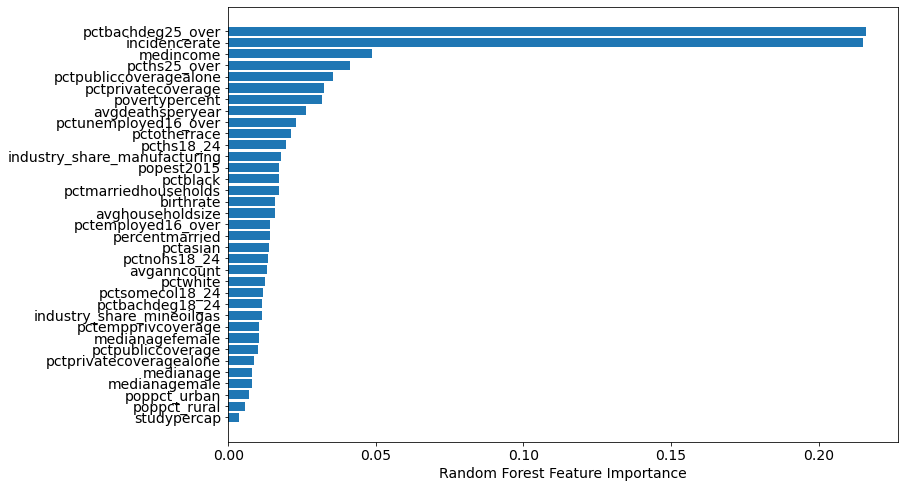

In [127]:
# building graph for the important features
plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})

# calculating the most important features
sorted_idx = rf5.feature_importances_.argsort()
plt.barh(X5.columns[sorted_idx], rf5.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")


### Cross-Validation

In [128]:
from sklearn.model_selection import cross_val_score

scores1 = cross_val_score(rf5,X=X5_train,y=y5_train, cv=10)
print ('Cross-validated scores:', scores1)
print('score_mean',scores1.mean(),': score_std',scores1.std())

Cross-validated scores: [0.59352364 0.60407223 0.54274849 0.4644253  0.55747385 0.60461747
 0.62304288 0.53407332 0.56532283 0.57233217]
score_mean 0.5661632171399651 : score_std 0.0435230910429866


## Model 7

### Exclude outliers from dependent variable

In [132]:
import scipy.stats as st
df6=reduced_df[(reduced_df['target_deathrate']>reduced_df['target_deathrate'].quantile(0.25)-(1.5*(st.iqr(reduced_df['target_deathrate']))))&(reduced_df['target_deathrate']<reduced_df['target_deathrate'].quantile(0.75)+(1.5*(st.iqr(reduced_df['target_deathrate']))))]

### X-Y-Split

In [133]:
# Split-Up numerical into X and Y
X_raw = df6.drop(['target_deathrate','ratioemployment','ratiocoverage','uv'], axis=1)
Y = df6['target_deathrate']

# Use Standard_Scaler
X_array = StandardScaler().fit_transform(X_raw)
X = pd.DataFrame(X_array, index=X_raw.index, columns=X_raw.columns)

### Train-Test-Split

In [134]:
# train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

### Linear Regression

In [135]:
# linear regression but this time with stats
import statsmodels.api as sm
modelOLS = sm.OLS(list(y_train),sm.add_constant(X_train)).fit()

C:\Users\flanc\.conda\envs\iron\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


### Identify significant features with p-values

In [136]:
features=[]
a=modelOLS.pvalues
for i in range(a.shape[0]):
    if  a[i]<0.05:
        features.append(a.index[i])
    else:
        continue
print(features)

['const', 'avganncount', 'incidencerate', 'medianagemale', 'percentmarried', 'pcths25_over', 'pctbachdeg25_over', 'pctemployed16_over', 'pctunemployed16_over', 'pctprivatecoverage', 'pctotherrace', 'pctmarriedhouseholds', 'birthrate', 'industry_share_manufacturing']


In [137]:
# new X
X = df6[['incidencerate', 'medincome', 'povertypercent', 'medianagemale', 'percentmarried', 'pcths25_over', 'pctbachdeg25_over', 'pctprivatecoverage', 'pctotherrace', 'pctmarriedhouseholds', 'birthrate', 'industry_share_manufacturing']]

### Check for features that are not normaly distributed

In [138]:
import scipy.stats as st

nor=[]
for i in  X.columns:
    if st.shapiro(X[i])[1]<0.05:
        nor.append(i)
    else:
        continue
print(nor)

['incidencerate', 'medincome', 'povertypercent', 'medianagemale', 'percentmarried', 'pcths25_over', 'pctbachdeg25_over', 'pctprivatecoverage', 'pctotherrace', 'pctmarriedhouseholds', 'birthrate', 'industry_share_manufacturing']


In [139]:
# write them into a new column for transforming
to_transform=X[['incidencerate', 'medincome', 'povertypercent', 'medianagemale', 'percentmarried', 'pcths25_over', 'pctbachdeg25_over', 'pctprivatecoverage', 'pctotherrace', 'pctmarriedhouseholds', 'birthrate', 'industry_share_manufacturing']]

### Train-Test-Split

In [140]:
# train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [141]:
X_train.min()

incidencerate                     201.30000
medincome                       22640.00000
povertypercent                      3.20000
medianagemale                      22.80000
percentmarried                     23.10000
pcths25_over                        7.50000
pctbachdeg25_over                   2.70000
pctprivatecoverage                 22.30000
pctotherrace                        0.00000
pctmarriedhouseholds               22.99249
birthrate                           0.00000
industry_share_manufacturing        0.00000
dtype: float64

### New Model

In [142]:
# set model to Linear Regression
model=LinearRegression()
# train the model
model.fit(X_train, y_train)

# Results
print('r2 score for train data :',model.score(X_train, y_train))
print('r2 score for test data :',model.score(X_test, y_test))

r2 score for train data : 0.4706272521731011
r2 score for test data : 0.426180415338794


### Polynominal features

In [143]:
# Importing and running Polynominal features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree = 2) 
X_poly = poly.fit_transform(X) 

# Do new train-test-split with poly features  
X_train, X_test , y_train, y_test = train_test_split(X_poly,Y, test_size = 0.20, random_state = 42)

### Linear regression

In [144]:
model2 = LinearRegression() 
model2.fit(X_train,y_train) 

#r2 for the train data
print('r2 score for train data :',model2.score(X_train, y_train))

#r2 for the test data
print('r2 score for test data :',model2.score(X_test, y_test))

r2 score for train data : 0.5481401988821959
r2 score for test data : 0.358610212748551


### Prediction

In [145]:
y_pred=model2.predict(X_test) 
result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

Text(0.5, 1.0, 'Test Set Residual histogram')

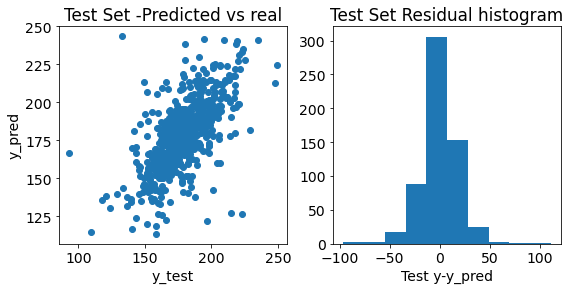

In [146]:
# Make an scatter plot y_pred vs y
# What kind of plot you will get if all the all the predictions are ok?
# A stright line

fig, ax = plt.subplots(1,2,figsize=(9,4))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

<AxesSubplot:xlabel='y_pred', ylabel='y_test'>

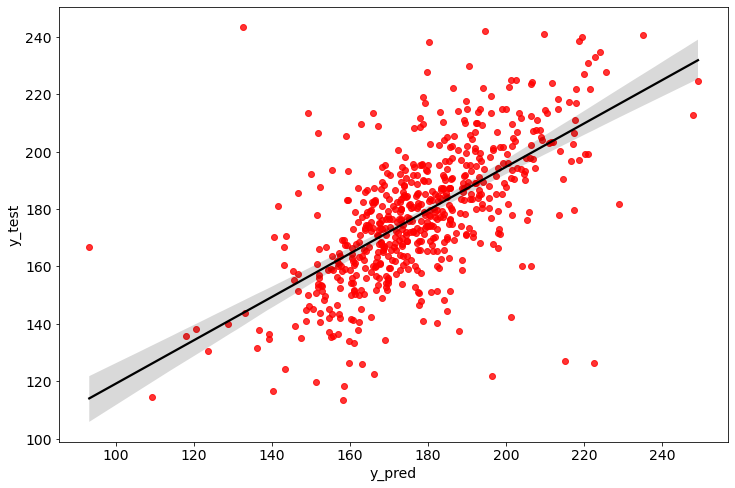

In [147]:
sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})

### Error Metrics

In [148]:
# Compute:
# ME: mean error
ME = np.mean( y_test - y_pred )

# MAE: mean absolute error
MAE = np.mean( np.abs( y_test - y_pred ) )

# MSE: mean squared error
MSE = np.mean( np.power( y_test - y_pred , 2 ) )

# RMSE: root mean squared error
RMSE = np.sqrt(MSE)

# MAPE: mean absolute percentual error
MAPE = np.mean( np.abs( y_test - y_pred) / y_test ) 

print('mean error: ' + str(round(ME,2)))
print('mean absolute error: ' + str(round(MAE,2)))
print('mean squared error: ' + str(round(MSE,2)))
print('root mean squared error: ' + str(round(RMSE,2)))
print('mean absolute percentual error: ' + str(round(MAPE,2)))

mean error: 0.04
mean absolute error: 13.31
mean squared error: 347.88
root mean squared error: 18.65
mean absolute percentual error: 0.08


### Cross Validation Score

In [149]:
from sklearn.model_selection import cross_val_score

scores1 = cross_val_score(model2,X=X_train,y=y_train, cv=10)
print ('Cross-validated scores:', scores1)
print('score_mean',scores1.mean(),': score_std',scores1.std())

Cross-validated scores: [0.33440128 0.38766098 0.52330498 0.55928713 0.52833015 0.50246712
 0.42484822 0.49265849 0.52449194 0.39820545]
score_mean 0.46756557451918496 : score_std 0.07145174397538855


## 5. Cancer incidences as dependent variable

### Clean Data

In [150]:
# Delete Alaska and Hawaii as the UV numbers are missing in the UV column
print(data_main.shape)
data_main.drop(data_main[data_main['state_short'] == 'AK'].index, inplace = True)
data_main.drop(data_main[data_main['state_short'] == 'HI'].index, inplace = True)
print(data_main.shape)

(3053, 45)
(3031, 45)


### Outliners

In [151]:
# Seperate the numerical numbers
numerical_incidence = data_main.select_dtypes('number')

# check IRQ
Q1 = numerical_incidence.quantile(0.25)
Q3 = numerical_incidence.quantile(0.75)
IQR = Q3 - Q1
print(IQR)




avganncount                       445.000000
avgdeathsperyear                  121.500000
target_deathrate                   33.950000
incidencerate                      60.100000
medincome                       13543.500000
popest2015                      56984.500000
povertypercent                      8.200000
studypercap                        83.811121
medianage                           6.200000
medianagemale                       6.200000
medianagefemale                     6.300000
avghouseholdsize                    0.260000
percentmarried                      8.600000
pctnohs18_24                        9.900000
pcths18_24                         11.450000
pctsomecol18_24                    12.700000
pctbachdeg18_24                     5.200000
pcths25_over                        9.300000
pctbachdeg25_over                   6.700000
pctemployed16_over                 12.000000
pctunemployed16_over                4.200000
pctprivatecoverage                 14.900000
pctprivate

In [152]:
# Count the outliers for each column

((numerical_incidence < (Q1 - 1.5 * IQR)) | (numerical_incidence > (Q3 + 1.5 * IQR))).sum()


avganncount                     461
avgdeathsperyear                348
target_deathrate                 62
incidencerate                    94
medincome                       117
popest2015                      411
povertypercent                   70
studypercap                     501
medianage                        94
medianagemale                    82
medianagefemale                  65
avghouseholdsize                190
percentmarried                   70
pctnohs18_24                     68
pcths18_24                       51
pctsomecol18_24                 114
pctbachdeg18_24                  88
pcths25_over                     29
pctbachdeg25_over                83
pctemployed16_over               45
pctunemployed16_over             64
pctprivatecoverage               19
pctprivatecoveragealone           5
pctempprivcoverage                9
pctpubliccoverage                15
pctpubliccoveragealone           35
pctwhite                        166
pctblack                    

In [153]:
# Delete Outliers from dependent variable as they are only 3% of sample size

df7=numerical_incidence[(numerical_incidence['incidencerate']>numerical_incidence['incidencerate'].quantile(0.25)-(1.5*(st.iqr(numerical_incidence['incidencerate']))))&(numerical_incidence['incidencerate']<numerical_incidence['incidencerate'].quantile(0.75)+(1.5*(st.iqr(numerical_incidence['incidencerate']))))]

In [154]:
df7

,avganncount,avgdeathsperyear,target_deathrate,incidencerate,medincome,popest2015,povertypercent,studypercap,medianage,medianagemale,...,pctotherrace,pctmarriedhouseholds,birthrate,industry_share_manufacturing,industry_share_mineoilgas,uv,poppct_urban,poppct_rural,ratioemployment,ratiocoverage
0,1397.000000,469,164.9,489.800000,61898,260131,11.2,499.748204,39.3,36.9,...,1.843479,52.856076,6.118831,2.542714,0.050196,3244.0,83.26,16.74,5.829581,1.208875
1,173.000000,70,161.3,411.600000,48127,43269,18.6,23.111234,33.0,32.2,...,3.741352,45.372500,4.333096,3.068327,0.006207,3806.0,59.94,40.06,5.829581,1.208875
2,102.000000,50,174.7,349.700000,49348,21026,14.6,47.560164,45.0,44.0,...,2.747358,54.444868,3.729488,18.080733,0.098422,4051.0,39.79,60.21,5.829581,1.208875
3,427.000000,202,194.8,430.400000,44243,75882,17.1,342.637253,42.8,42.2,...,1.362643,51.021514,4.603841,10.155325,1.170562,3425.0,39.35,60.65,5.829581,1.208875
4,57.000000,26,144.4,350.100000,49955,10321,12.5,0.000000,48.3,47.8,...,0.492135,54.027460,6.796657,0.000000,0.326622,3870.0,0.00,100.00,5.829581,1.208875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3048,1962.667684,15,149.6,453.549422,46961,6343,12.4,0.000000,44.2,41.1,...,1.700468,51.063830,7.773512,15.817909,3.937987,4581.0,45.90,54.10,13.217273,1.226752
3049,1962.667684,43,150.1,453.549422,48609,37118,18.8,377.175494,30.4,29.3,...,14.130288,52.007937,8.186470,21.138494,2.354351,4873.0,81.42,18.58,13.217273,1.226752
3050,1962.667684,46,153.9,453.549422,51144,34536,15.0,1968.959926,30.9,30.5,...,5.680705,55.153949,7.809192,31.452893,0.308944,4848.0,80.70,19.30,13.217273,1.226752
3051,1962.667684,52,175.0,453.549422,50745,25609,13.3,0.000000,39.0,36.9,...,2.131790,58.484232,7.582938,12.407903,0.694306,4322.0,47.90,52.10,13.217273,1.226752


### Kick out highly correlating columns

In [155]:
# Create correlation matrix
corr_df = df7.corr().abs()
# Select upper traingular
upper_tri = corr_df.where(np.triu(np.ones(corr_df.shape),k=1).astype(np.bool_))
# Save highly correlating features r>0.9 in the list to_drop
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]
# Drop the features from the to_drop list and create a reduced DataFrame
reduced_df7 = df7.drop(df7[to_drop], axis=1)

print("The reduced dataframe has {} columns.".format(reduced_df7.shape[1]))

The reduced dataframe has 33 columns.


### Create Bins to deal with outliers without reducing the sample size to much

In [156]:
df7_bins = pd.DataFrame()
for i, column in enumerate(reduced_df7):
    df7_bins[column] = pd.qcut(reduced_df7[column],5,duplicates='drop',labels=False)
print (df7_bins)

      avganncount  target_deathrate  incidencerate  medincome  povertypercent  \
0               4                 1              4          4               0   
1               2                 1              0          3               3   
2               1                 2              0          3               2   
3               3                 3              1          2               2   
4               0                 0              0          3               1   
...           ...               ...            ...        ...             ...   
3048            4                 0              2          2               1   
3049            4                 0              2          3               3   
3050            4                 0              2          3               2   
3051            4                 2              2          3               1   
3052            4                 4              2          1               1   

      studypercap  medianag

In [157]:
df7_bins.isna().sum()

avganncount                     0
target_deathrate                0
incidencerate                   0
medincome                       0
povertypercent                  0
studypercap                     0
medianage                       0
medianagemale                   0
avghouseholdsize                0
percentmarried                  0
pctnohs18_24                    0
pcths18_24                      0
pctsomecol18_24                 0
pctbachdeg18_24                 0
pcths25_over                    0
pctbachdeg25_over               0
pctemployed16_over              0
pctunemployed16_over            0
pctprivatecoverage              0
pctpubliccoverage               0
pctpubliccoveragealone          0
pctwhite                        0
pctblack                        0
pctasian                        0
pctotherrace                    0
pctmarriedhouseholds            0
birthrate                       0
industry_share_manufacturing    0
industry_share_mineoilgas       0
uv            

### X-Y-Split

In [158]:
# Split-Up numerical into X and Y
X1_raw = reduced_df7.drop(['incidencerate','ratioemployment','ratiocoverage','uv'], axis=1)
Y1 = reduced_df7['incidencerate']

# Use Standard_Scaler
X1_array = StandardScaler().fit_transform(X1_raw)
X1 = pd.DataFrame(X1_array, index=X1_raw.index, columns=X1_raw.columns)

### Train-Test-Split

In [159]:
# train-test-split
X_train, X_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.20, random_state=42)

### Model

In [160]:
# set model to Linear Regression
model=LinearRegression()
# train the model
model.fit(X_train, y_train)

# Results
print('r2 score for train data :',model.score(X_train, y_train))
print('r2 score for test data :',model.score(X_test, y_test))

r2 score for train data : 0.3346729046882245
r2 score for test data : 0.3438933462712963


In [161]:
y_pred=model.predict(X_test)   # model prediction
y_pred

result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

<AxesSubplot:xlabel='y_pred', ylabel='y_test'>

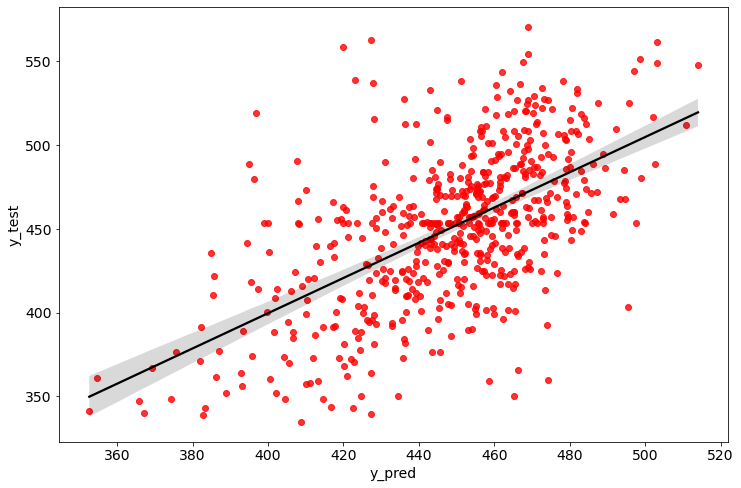

In [162]:
sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})

### Identify significant features 

In [163]:
# linear regression but this time with stats
import statsmodels.api as sm
modelOLS = sm.OLS(list(y_train),sm.add_constant(X_train)).fit()

C:\Users\flanc\.conda\envs\iron\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [164]:
features=[]
a=modelOLS.pvalues
for i in range(a.shape[0]):
    if  a[i]<0.05:
        features.append(a.index[i])
    else:
        continue
print(features)

['const', 'avganncount', 'target_deathrate', 'medincome', 'avghouseholdsize', 'pctunemployed16_over', 'pctprivatecoverage', 'pctpubliccoveragealone', 'pctotherrace', 'pctmarriedhouseholds', 'industry_share_manufacturing', 'industry_share_mineoilgas', 'poppct_urban']


In [165]:
#Keep only significant features plus dependent feature
df7_n = df7[['incidencerate','avganncount', 'target_deathrate', 'medincome', 'avghouseholdsize', 'pctunemployed16_over', 'pctprivatecoverage', 'pctpubliccoveragealone', 'pctotherrace', 'pctmarriedhouseholds', 'industry_share_manufacturing', 'industry_share_mineoilgas', 'poppct_urban']]

### redo outlier check

In [166]:
# check IRQ
Q1 = df7_n.quantile(0.25)
Q3 = df7_n.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

incidencerate                      57.300000
avganncount                       469.000000
target_deathrate                   33.400000
medincome                       13396.000000
avghouseholdsize                    0.260000
pctunemployed16_over                4.100000
pctprivatecoverage                 14.700000
pctpubliccoveragealone              8.100000
pctotherrace                        1.882006
pctmarriedhouseholds                7.580224
industry_share_manufacturing       17.320834
industry_share_mineoilgas           1.642734
poppct_urban                       50.830000
dtype: float64


In [167]:
# count number of outliers 

((df7_n < (Q1 - 2 * IQR)) | (df7_n > (Q3 + 2 * IQR))).sum()

incidencerate                     0
avganncount                     409
target_deathrate                 15
medincome                        66
avghouseholdsize                123
pctunemployed16_over             35
pctprivatecoverage                5
pctpubliccoveragealone            9
pctotherrace                    218
pctmarriedhouseholds             42
industry_share_manufacturing     32
industry_share_mineoilgas       490
poppct_urban                      0
dtype: int64

In [168]:
# cut columns avganncount & industry_share_mineoilgas
df7_n = df7_n.drop(['avganncount','industry_share_mineoilgas'], axis=1)

In [169]:
# Let's do it again
# check IRQ
Q1 = df7_n.quantile(0.25)
Q3 = df7_n.quantile(0.75)
IQR = Q3 - Q1
((df7_n < (Q1 - 1.5 * IQR)) | (df7_n > (Q3 + 1.5 * IQR))).sum()

incidencerate                    23
target_deathrate                 50
medincome                       115
avghouseholdsize                176
pctunemployed16_over             64
pctprivatecoverage               19
pctpubliccoveragealone           34
pctotherrace                    282
pctmarriedhouseholds             94
industry_share_manufacturing     84
poppct_urban                      0
dtype: int64

In [170]:
# Exclude outliers from all independent features left

df7_o = df7_n[~((df7_n < (Q1 - 1.5 * IQR)) |(df7_n > (Q3 + 1.5 * IQR))).any(axis=1)]
print(df7_n.shape)
print(df7_o.shape)

(2937, 11)
(2233, 11)


### X-Y-Split

In [171]:
# Split-Up numerical into X and Y
X_raw = df7_o.drop(['incidencerate'], axis=1)
Y = df7_o['incidencerate']

# Use Standard_Scaler
X_array = StandardScaler().fit_transform(X_raw)
X = pd.DataFrame(X_array, index=X_raw.index, columns=X_raw.columns)

### Train-Test-Split

In [172]:
# train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

### New Model

In [173]:
# set model to Linear Regression
model=LinearRegression()
# train the model
model.fit(X_train, y_train)

# Results
print('r2 score for train data :',model.score(X_train, y_train))
print('r2 score for test data :',model.score(X_test, y_test))

r2 score for train data : 0.27222216578333513
r2 score for test data : 0.1759816898044836


In [174]:
y_pred=model.predict(X_test)   # model prediction
y_pred

result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

<AxesSubplot:xlabel='y_pred', ylabel='y_test'>

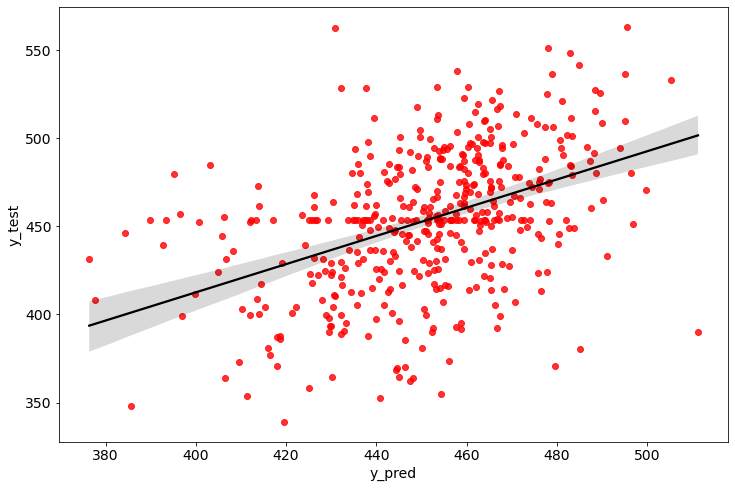

In [175]:
sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})